In [1]:
"""
------------------------
Last Updated: 28/05/2022
------------------------
----------------------------------------
THIS NOTEBOOK NEEDS TO BE MORE ORGANIZED 
-----------------------------------------

The purpose of this notebook is to get a idea of how the translation of the smiles to 
the coarse-grained beads of Martini can work. 

-> https://cedric.bouysset.net/blog/2020/08/07/rdkit-interoperability
-> https://stackoverflow.com/questions/47319238/python-plot-3d-vectors
-> https://en.wikipedia.org/wiki/XYZ_file_format - information on the xyz coordination file 
-> https://mattermodeling.stackexchange.com/questions/3961/recalculate-atom-positions-to-account-for-periodic-boundary-conditions/3970#3970  - Atomsk
-> https://stackoverflow.com/questions/49064611/how-to-find-different-groups-in-networkx-using-python - grouping networks 
-> https://www.mdanalysis.org/2020/08/29/gsoc-report-cbouy/
-> http://cgmartini.nl/index.php/component/kunena/8-martini-philosophy/5776-mapping-of-benzene-ring
-> https://docs.mdanalysis.org/1.0.0/documentation_pages/lib/NeighborSearch.html
-> https://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d
-> https://sphinxcontrib-napoleon.readthedocs.io/en/latest/example_numpy.html
-> https://nanotube.msu.edu/fullerene/fullerene-isomers.html
-> https://towardsdatascience.com/molecular-visualization-in-streamlit-using-rdkit-and-py3dmol-part-2-657d28152753
-> https://plotly.com/python/3d-scatter-plots/
-> https://undergroundmathematics.org/circles/cutting-spheres/solution
-> https://www.ossila.com/products/pc70bm - pcbm 
-> https://github.com/mosdef-hub/nanoparticle_optimization
-> https://pubs.acs.org/doi/10.1021/acs.jctc.8b01269

Quote by Riccardo: 
------------------
In the open beta of Martini 3, benzene is indeed mapped with three TC4 beads, that that's again a 2-to-1 mapping. 
The bond length is changed to 0.29 nm in 3.0 because this allows to represent more closely the volume of a benzene 
molecule, taking into account also the smaller size of T-beads as compared to S -beads

---------------------------
How the modules are divided
---------------------------

-> We want to be given free reign into making NPs of multiple types. The primary types we are concerned with at the 
   moment is 
   
   1. Functionalized AuNP type ones.  
   2. Carbon Nanotube like ones. 
   3. Large spherical buckyball type structures - Like C70. 

-> TODO  
   - Am not able to get the box dimenisons correct for the xyz file...
   - Need to write Striped/Janus functionality to the NP maker  

Trying to translate the atomic C70 structure into the coarse-grained c70 structure 

TODO - isolate per 2 beads - There is a two to one mapping, and find the center of mass 
       for each of these beads. Then construct the itp file for the bead. 

"""



"\n------------------------\nLast Updated: 28/05/2022\n------------------------\n----------------------------------------\nTHIS NOTEBOOK NEEDS TO BE MORE ORGANIZED \n-----------------------------------------\n\nThe purpose of this notebook is to get a idea of how the translation of the smiles to \nthe coarse-grained beads of Martini can work. \n\n-> https://cedric.bouysset.net/blog/2020/08/07/rdkit-interoperability\n-> https://stackoverflow.com/questions/47319238/python-plot-3d-vectors\n-> https://en.wikipedia.org/wiki/XYZ_file_format - information on the xyz coordination file \n-> https://mattermodeling.stackexchange.com/questions/3961/recalculate-atom-positions-to-account-for-periodic-boundary-conditions/3970#3970  - Atomsk\n-> https://stackoverflow.com/questions/49064611/how-to-find-different-groups-in-networkx-using-python - grouping networks \n-> https://www.mdanalysis.org/2020/08/29/gsoc-report-cbouy/\n-> http://cgmartini.nl/index.php/component/kunena/8-martini-philosophy/5776-ma

In [51]:
# Boilerplate libraries                                                                                                                                                                                    
import sys                                                                                                                                                                                                 
import re                                                                                                                                                                                                  
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import math 
from operator import itemgetter
import itertools                                                                                                                                                                                           
import requests                                                                                                                                                                                            
import collections                                                                                                                                                                                         
import random            

# Scipy libraries 
import scipy                                                                                                                                                                                                                                                                                                                                                                                                          
from scipy.sparse import csr_matrix                                                                                                                                                                        
from scipy.sparse.csgraph import floyd_warshall                                                                                                                                                            
from scipy.spatial import ConvexHull, convex_hull_plot_2d 
from scipy.linalg import solve
from scipy.spatial import distance

# Rdkit libraries 
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem import AllChem                                                                                                                                                                             
from rdkit.Chem import ChemicalFeatures                                                                                                                                                                    
from rdkit.Chem import rdchem                                                                                                                                                                              
from rdkit.Chem import rdMolDescriptors                                                                                                                                                                    
from rdkit import RDConfig  

# Alignment libraries in MDAnalysis
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import rmsd
#from MDAnalysis.tests.datafiles import PSF, DCD, PDB_small, PDB, XTC

# Matplotlib libraries 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import axes3d    
from mpl_toolkits.mplot3d import Axes3D

# plotly functionalities 
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

# Abstract classes and methodology 
from abc import ABC, abstractmethod

# logging module 
import logging 
logging.basicConfig(level = logging.INFO)
# Change logging configurations so that we are printing out 

# - -
import parmed as pmd
from parmed.gromacs.gromacstop import GromacsTopologyFile

pd.set_option('display.max_colwidth', None)
IPythonConsole.ipython_useSVG=True  #< set this to False if you want PNGs instead of SVGs

In [3]:
def AttachLigandsMartiniOriginal(GroFiles, FirstAtoms, LastAtoms, SphereList, option = 'Plain'):
    """
    
    """
    Molecule, TransformationList, LigandAlignmentVector = ReadMartiniMolecules(
        GroFiles[0], FirstAtom[0], LastAtom[0])
    
    LigandList, NameList = [], []
    Sphere = []
    Xplot, Yplot, Zplot = [], [], []
    XplotSphere, YplotSphere, ZplotSphere = [], [], []

    # Sulfur/ligand vector 
    unitVector = np.linalg.norm(LigandAlignmentVector)
    vec1 = LigandAlignmentVector.tolist()
    
    for index in range(0, len(SphereList)):
        vec2 = SphereList[index] 
        # Find the rotation matrix that aligns ligand vector representation to the NP surface vector point representation 
        TransformationVector = rotation_matrix_from_vectors(vec1, vec2)  
        vec1_rot = TransformationVector.dot(vec1) # Rotate the vector to match the surface point on the sphere 
        # TODO 
        unitVectorabs = np.linalg.norm(LigandAlignmentVector)  
        vecMultiplier = vec1_rot/unitVectorabs * 2 # Controls how far we want the ligands to be placed away from
                                               # the NP surface
        # TODO
        Sphere.append(vec1_rot.tolist())
        #LigandList.append(vec1_rot.tolist())
        # Get the factors to translate the vector 
        for trans in TransformationList:
            #if vec1_rot[0] > 0 and vec1_rot[1] > 0 and vec1_rot[2] > 0:   # (+ , +, +)
            LigandAtomcoordinate = TransformationVector.dot(trans[0])
            LigandAtomcoordinate[0] = LigandAtomcoordinate[0] + vecMultiplier[0]
            LigandAtomcoordinate[1] = LigandAtomcoordinate[1] + vecMultiplier[1]
            LigandAtomcoordinate[2] = LigandAtomcoordinate[2] + vecMultiplier[2]
            LigandList.append(LigandAtomcoordinate.tolist()) # Append coordinates of the 
            NameList.append(trans[1]) # Append the names of the atoms 

    # Append the coordinates of the ligands 
    for index, entry in enumerate(LigandList):
        #ax.plot3D(entry[0], entry[1], entry[2], 'red')
        Xplot.append(entry[0])
        Yplot.append(entry[1])
        Zplot.append(entry[2])
        
    # Add in the ligand index 
    LigandConstituent = [atom.name for atom in Molecule]
    Ligands = []
    for index in range(0, len(Sphere)): 
        Ligands = Ligands + LigandConstituent
    
    SphereName = [] 
    # Append the coordinates of the sphere 
    for entry in Sphere:
        #ax.plot3D(entry[0], entry[1], entry[2], 'red')
        XplotSphere.append(entry[0])
        YplotSphere.append(entry[1])
        ZplotSphere.append(entry[2])
        SphereName.append('Au')
    
    dfLigand = pd.DataFrame(list(zip(Xplot, Yplot, Zplot, Ligands)), columns =['X', 'Y', 'Z', 'NAME'])
    dfLigand['name'] = 'Ligand'
    dfCore = pd.DataFrame(list(zip(XplotSphere, YplotSphere, ZplotSphere, SphereName)), columns =['X', 'Y', 'Z', 'NAME'])
    dfCore['name'] = 'Core'
    Total = dfLigand.append(dfCore)
    return Total
    
def ComputeC70Distances(coordinate):
    """    
    
    Args:
        coordinate: 
            path and file where the pdb file is.
    Returns: 
        
    Raises:
    
    
    """
    u = mda.Universe(coordinate)
    
    CorePositions, CoreIndex = [], []
    C70CGBeadPositions = []
    DistanceDict = {}
    CorePositions = [[index, atoms.position] for index, atoms in enumerate(u.atoms)]
    
    for index, atoms in enumerate(u.atoms): # iterate through items 
        DistanceDict[index] = []
        # Get the distance between atoms in the core positions  
        for items in CorePositions:
            # Find the distance between the index atoms in the index, atom.. 
            # and the core 
            dist = distance.euclidean(items[1], atoms.position)
            Entry = [index, items[0], dist]
            # Sort entry by dist 
            DistanceDict[index].append(Entry)
    ClosestAtomsDistance = [] # List to store the atoms with the closest distances
    # Sort each entry by distance 
    
    for key in DistanceDict.keys():
        DistanceDict[key] = sorted(DistanceDict[key], key=itemgetter(2)) # sort entries by closest distance 
        DistanceDict[key][1][0:2] = sorted(DistanceDict[key][1][0:2]) # 
        ClosestAtomsDistance.append(DistanceDict[key][1])
    # Remove duplicate entries 
    UniqueSetsCoordinates = [list(x) for x in set(tuple(x) for x in ClosestAtomsDistance)]       
    # Take the indices in the unique data and compute the averge coordinates
    
    for entry in UniqueSetsCoordinates:
        data = [list(CorePositions[entry[0]][1]), list(CorePositions[entry[1]][1])]
        averaged = np.average(data, axis=0)
        C70CGBeadPositions.append(averaged)
        
    return C70CGBeadPositions


def AttachLigandsOriginal(LigandSmilesString, FirstAtomList, LastAtomList, SphereList):
    """ The original Attach ligands function 
    
    This function takes a smiles strings, orientates 
    the ligand of that of the smiles string, and then positions them onto the 
    surface of the NP

    Args:
        LigandSmilesString: 
            smiles of the ligand we want to attach. We want to give a list 
            as we want to have the options of attaching the ligands onto 
            a Janus or Striped NP 
        FirstAtomList:
            Name of the first atoms in the ligands
        LastAtomList: 
            Name of the last atoms in the ligands  
        SphereList:
            The core which has been generated by GenerateCore function     
    Returns:
        Placeholder:
    Raises:
        Placeholder: 
    """
    Molecule = u.select_atoms('all')
    # Select Atom attached to the core 
    FirstAtom = u.select_atoms('name {}'.format(FirstAtomList[0])) # Pick out the atoms attached
    # Select end atom on the ligand 
    LastAtom = u.select_atoms('name {}'.format(LastAtomList[0])) # Pick out the last atom at the tip of the ligand 
    TransformationList, NameList = [], []
    # Find the vector representing the direction from the sulfur to the tip of the ligand. 
    LigandAlignmentVector = (FirstAtom.positions- LastAtom.positions)[0]  
    
    
    for i,j in enumerate(Molecule.positions):
        vector = (j - FirstAtom.positions)[0]
        vector[0] = LigandAlignmentVector[0] - vector[0]
        vector[1] = LigandAlignmentVector[1] - vector[1]    
        vector[2] = LigandAlignmentVector[2] - vector[2]
        if vector[0] == -math.inf:
            pass
        if vector[0] == 0.0:
            pass
        else:
            TransformationList.append([vector, Molecule.atoms[i].type])     
            
    LigandList = [] 
    Sphere = []
    Xplot, Yplot, Zplot = [], [], []
    XplotSphere, YplotSphere, ZplotSphere = [], [], []
    # Sulfur/ligand vector 
    unitVector = np.linalg.norm(LigandAlignmentVector)
    vec1 = LigandAlignmentVector.tolist()
    
    
    for index in range(0, len(SphereList)):
        vec2 = SphereList[index] 
        # Find the rotation matrix that aligns ligand vector representation to the NP surface vector point representation 
        TransformationVector = rotation_matrix_from_vectors(vec1, vec2)  
        vec1_rot = TransformationVector.dot(vec1) # Rotate the vector to match the surface point on the sphere 
        # TODO 
        unitVectorabs = np.linalg.norm(LigandAlignmentVector)  
        vecMultiplier = vec1_rot/unitVectorabs * 3 # Controls how far we want the ligands to be placed away from
                                               # the NP surface
        # TODO
        Sphere.append(vec1_rot.tolist())
        # Get the factors to translate the vector 
        for trans in TransformationList:
            #if vec1_rot[0] > 0 and vec1_rot[1] > 0 and vec1_rot[2] > 0:   # (+ , +, +)
            LigandAtomcoordinate = TransformationVector.dot(trans[0])
            LigandAtomcoordinate[0] = LigandAtomcoordinate[0] + vecMultiplier[0]
            LigandAtomcoordinate[1] = LigandAtomcoordinate[1] + vecMultiplier[1]
            LigandAtomcoordinate[2] = LigandAtomcoordinate[2] + vecMultiplier[2]
            LigandList.append(LigandAtomcoordinate.tolist()) # Append coordinates of the 
            NameList.append(trans[1]) # Append the names of the atoms 

    # Append the coordinates of the ligands 
    for index, entry in enumerate(LigandList):
        #ax.plot3D(entry[0], entry[1], entry[2], 'red')
        Xplot.append(entry[0])
        Yplot.append(entry[1])
        Zplot.append(entry[2])
        
    # Add in the ligand index 
    LigandConstituent = [atom.name for atom in Molecule]
    Ligands = []
    for index in range(0, len(Sphere)): 
        Ligands = Ligands + LigandConstituent
    
    SphereName = [] 
    # Append the coordinates of the sphere 
    for entry in Sphere:
        #ax.plot3D(entry[0], entry[1], entry[2], 'red')
        XplotSphere.append(entry[0])
        YplotSphere.append(entry[1])
        ZplotSphere.append(entry[2])
        SphereName.append('Au')
    
    dfLigand = pd.DataFrame(list(zip(Xplot, Yplot, Zplot, Ligands)), columns =['X', 'Y', 'Z', 'NAME'])
    dfLigand['name'] = 'Ligand'
    dfCore = pd.DataFrame(list(zip(XplotSphere, YplotSphere, ZplotSphere, SphereName)), columns =['X', 'Y', 'Z', 'NAME'])
    dfCore['name'] = 'Core'
    Total = dfLigand.append(dfCore)
    return Total




In [56]:
class MDNPPackage(object):
    def __init__(self):
        """
        """
        self.FibSphere = []
        self.BatchSphereCoordinates = None
        
    def Fibanocci_Sphere(samples=1):
        """ Return a Fibanocci sphere with N number of points on the surface. 

        This will act as the template for the nanoparticle core. 
    
        Args:
            Placeholder
        Returns:
            Placeholder
        Raises:
            Placeholder
        """
        #points = []
        phi = math.pi * (3. - math.sqrt(5.))  # golden angle in radians

        for i in range(samples):
            y = 1 - (i / float(samples - 1)) * 2  # y goes from 1 to -1
            radius = math.sqrt(1 - y * y)  # radius at y
            theta = phi * i  # golden angle increment
            x = math.cos(theta) * radius
            z = math.sin(theta) * radius
            self.FibSphere.append((x, y, z))
            
    def rotation_matrix_from_vectors(vec1, vec2):
        """ Find the rotation matrix that aligns vec1 to vec2
        Args:
            vec1: 
                A 3d "source" vector
            vec2: 
                A 3d "destination" vector
        Returns:
            rotation_matrix:
                A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
        Raises:
        """
        a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
        v = np.cross(a, b)
        c = np.dot(a, b)
        s = np.linalg.norm(v)
        kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
        self.rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))

        
    def LabelStripedNP(Core, Type = 'Janus'):
        """Placeholder
    
        Depending on the type of NP we want in the input, we can try to generate 
        different patterns on the surface of the spehre, which will help us generate the 
        lists correponding to the anisotropic nature of the NP. 
    
        The types of NPs we can currently have are:
        
        - Janus 
        - Striped
    
        More options will be added. As in its current iteraton:
    
        1. The Janus type divides the NP into two hemispheres.
    
        2. The Striped type divides the NP into three hemispheres, typically used with a hydrophobic middle 
        especially when it comes to using with biosimulations. 
        
        Args:
            Core: 
                Placeholder
            Type:
                Placeholder
        Returns:
    
        Raises:

        """
        XCoordinates = [i[0] for i in Core] # Find x coordinates
        YCoordinates = [i[1] for i in Core] # Find y coordinates
        ZCoordinates = [i[2] for i in Core] # Find z coordinates 
        Length = 2 * abs(max(ZCoordinates)) # From 2 * the radius, we know the total length of the NP 
    
        if Type == 'Striped':
            # As we have a spherical structure, we just need to find the minimum/maximum in 
            # one of the axes to find that for the rest 
            # define the threshold for how you wish to generate the NP with striped pattern 
            Threshold = Length / 3 
            # Find the central band of the sphere where you wish to put 
            # different ligands 
            StripedValues = [i for i in Core if i[2] > (min(ZCoordinates) + Threshold) and i[2] < (max(ZCoordinates) - Threshold)] # Return middle strip values
            CeilingValues = [i for i in Core if i not in StripedValues] # Return top 'ceiling' strip values 
            return StripedValues, CeilingValues
        elif Type == 'Janus':
            Threshold = Length / 2 
            TopValues = [i for i in Core if i[2] > (min(ZCoordinates) + Threshold)] # Return top hemipshere 
            BotValues = [i for i in Core if i not in TopValues] # Return bottom hemisphere 
            return TopValues, BotValues
        
    def GenerateCore(Radius, N, Option = 'Plain'):
        """ Creates a Fibanocci sphere that represents the NP core 
        and allocates the radius. Using the radius, 
    
        The core is scaled down/up to the size that one wishes to have. 
        We can generate arrays corresponding  to a plain core, or a tuple with 
        two entries with different parts of the NP core that corresponds to positions 
        with striped or janus type positions.
    
        Args:
            Radius: 
                The radius of the core of the NP 
            N: 
                The number of core 'atoms' we want create that constitutes the core 
            Option (default = 'Plain'):
                If the option is plain, we simply return a single list. Otherwise, 
                we generate a tuple which separates out core atoms.
        Returns:
    
        Raises: 
    
        """
        Sphere = FibanocciSphere(N) # Create the fibanocci sphere representing the NP core 
        XSphere, YSphere, ZSphere  = [], [], []
    
        for entry in Sphere:
            XSphere.append(entry[0])
            YSphere.append(entry[1])
            ZSphere.append(entry[2])
        
        # Append as 2d list
        SphereList = [] 
        for index in range(0, len(XSphere)):
            SphereList.append([XSphere[index], YSphere[index], ZSphere[index]])
        # Take the radius value, and then multiply the unit vector in each 
        # Direction by that radius value to increase the total volume of the 
        # NP core.
        for index in range(0, len(SphereList) -1):
            SphereList[index][0] = SphereList[index][0] * Radius
            SphereList[index][1] = SphereList[index][1] * Radius
            SphereList[index][2] = SphereList[index][2] * Radius
        # Return just the whole list without any further modifications
        if Option == 'Plain':
            return [SphereList[1:-1]]
        # Separate out the anisotropy for the striped variant 
        elif Option == 'Striped':
            StripedValues, CeilingValues = LabelStripedNP(SphereList[1:-1], Option)
            return StripedValues, CeilingValues
        # Separate out the anisotropy for the Janus variant 
        elif Option == 'Janus':
            TopValues, BottomValues = LabelStripedNP(SphereList[1:-1], Option)
            return TopValues, BottomValues  
        
        
    def ReturnPandasNP(LigandString, FirstAtom, LastAtom, SphereList, 
                   LigandName, CoreName, Length = 1.0):
        """Placeholder
    
        Also needs to return the indices i,j of the sulfur 
        ligands, with the 
    
        , and the distance between the 
    
        Args:
        Returns:
        Raises:    
        """
        TransformationList, NameList = [], [] # 
        LigandList = [] 
        Sphere = []
        Xplot, Yplot, Zplot = [], [], []
        XplotSphere, YplotSphere, ZplotSphere = [], [], []
        
        u = mda.Universe.from_smiles(LigandString)
        Ligand = u.select_atoms('all')
        logging.info(f"The length of the ligand is {len(Ligand)}")
        FirstAtomGroup = u.select_atoms('name {}'.format(FirstAtom))
        LastAtomGroup = u.select_atoms('name {}'.format(LastAtom))
        LigandAlignmentVector = (FirstAtomGroup.positions- LastAtomGroup.positions)[0]
    
        for i,j in enumerate(Ligand.positions):
            vector = (j - FirstAtomGroup.positions)[0]
            vector[0] = LigandAlignmentVector[0] - vector[0]
            vector[1] = LigandAlignmentVector[1] - vector[1]    
            vector[2] = LigandAlignmentVector[2] - vector[2]
            if vector[0] == -math.inf:
                pass
            if vector[0] == 0.0:
                pass
            else:
                TransformationList.append([vector, Ligand.atoms[i].type])        
        
        unitVector = np.linalg.norm(LigandAlignmentVector)
        vecLigand = LigandAlignmentVector.tolist()
    
        # Loop over the sphere and find the 
        for index in range(0, len(SphereList)):
            vec2 = SphereList[index]
            # Find the transformationvector for the ligand vector to vec2, which is the position of the point on sphere
            TransformationVector = rotation_matrix_from_vectors(vecLigand, vec2)
            # Rotate the vector 
            vec1_rot = TransformationVector.dot(vecLigand) # Rotate the vector to match the surface point on the sphere 
            # Get the absolute length of the unit vector 
            unitVectorabs = np.linalg.norm(LigandAlignmentVector)
            # Change the rotation vector in unit vector, then multiply by the absolute 
            # length of the sphere 
            vecMultiplier = vec1_rot/unitVectorabs * (np.linalg.norm(np.array(vec2))) + (vec1_rot/unitVectorabs * Length)
            # Find the difference in length 
        
            Sphere.append(vec2)
        
            # Translate the vector further out 
            for trans in TransformationList:
                LigandAtomcoordinate = TransformationVector.dot(trans[0])
                LigandAtomcoordinate[0] = LigandAtomcoordinate[0] + vecMultiplier[0]
                LigandAtomcoordinate[1] = LigandAtomcoordinate[1] + vecMultiplier[1]
                LigandAtomcoordinate[2] = LigandAtomcoordinate[2] + vecMultiplier[2]
                LigandList.append(LigandAtomcoordinate.tolist()) # Append coordinates of the 
                NameList.append(trans[1]) # Append the names of the atoms
    
        # Append the coordinates of the ligands 
        for index, entry in enumerate(LigandList):
            Xplot.append(entry[0])
            Yplot.append(entry[1])
            Zplot.append(entry[2])  
    
        LigandConstituent = [atom.name for atom in Ligand]
        Ligands = [] # TODO 
        for index in range(0, len(Sphere)): 
            Ligands = Ligands + LigandConstituent

        SphereName = [] 
        # Append the coordinates of the sphere 
        for entry in Sphere:
            XplotSphere.append(entry[0])
            YplotSphere.append(entry[1])
            ZplotSphere.append(entry[2])
            SphereName.append('Au')
    
        dfLigand = pd.DataFrame(list(zip(Xplot, Yplot, Zplot, Ligands)), columns =['X', 'Y', 'Z', 'NAME'])
        dfCore = pd.DataFrame(list(zip(XplotSphere, YplotSphere, ZplotSphere, SphereName)), columns =['X', 'Y', 'Z', 'NAME'])
        dfLigand['name'] = LigandName
        dfCore['name'] = CoreName
        
        return dfLigand, dfCore
    
    
    def ReturnPandasNPMartini(Molecule, LigandAlignmentVector, TransformationList, SphereList, LigandName, 
                          CoreName, Length = 1.0):
        """ Function to read Martini molecule information and orientate on NP surface 
        
        Args:
            Placeholder
        Returns: 
            Placeholder
        Raises:
            Placeholder 
        """
        LigandList, NameList = [], []
        Sphere = []
        Xplot, Yplot, Zplot = [], [], []
        XplotSphere, YplotSphere, ZplotSphere = [], [], []

        # Sulfur/ligand vector 
        unitVector = np.linalg.norm(LigandAlignmentVector)
        vec1 = LigandAlignmentVector.tolist()
        for index in range(0, len(SphereList)):
            vec2 = SphereList[index] 
            # Find the rotation matrix that aligns ligand vector representation to the NP surface vector point representation 
            TransformationVector = rotation_matrix_from_vectors(vec1, vec2)  
            vec1_rot = TransformationVector.dot(vec1) # Rotate the vector to match the surface point on the sphere 
            # TODO 
            unitVectorabs = np.linalg.norm(LigandAlignmentVector)  
            #vecMultiplier = vec1_rot * (np.linalg.norm(np.array(vec2))) # Controls how far we want the ligands to be placed away from
                                               # the NP surface
            #vecMultiplier = [1.0, 1.0, 1.0]
            vecMultiplier = vec1_rot/unitVectorabs * (np.linalg.norm(np.array(vec2))) + (vec1_rot/unitVectorabs * Length)
            #Sphere.append(vec1_rot.tolist())
            Sphere.append(vec2)
            # Get the factors to translate the vector 
            for trans in TransformationList:
                #if vec1_rot[0] > 0 and vec1_rot[1] > 0 and vec1_rot[2] > 0:   # (+ , +, +)
                LigandAtomcoordinate = TransformationVector.dot(trans[0])
                LigandAtomcoordinate[0] = LigandAtomcoordinate[0] + vecMultiplier[0]
                LigandAtomcoordinate[1] = LigandAtomcoordinate[1] + vecMultiplier[1]
                LigandAtomcoordinate[2] = LigandAtomcoordinate[2] + vecMultiplier[2]
                LigandList.append(LigandAtomcoordinate.tolist()) # Append coordinates of the 
                NameList.append(trans[1]) # Append the names of the atoms 

        # Append the coordinates of the ligands 
        for index, entry in enumerate(LigandList):
            #ax.plot3D(entry[0], entry[1], entry[2], 'red')
            Xplot.append(entry[0])
            Yplot.append(entry[1])
            Zplot.append(entry[2])
        
        # Add in the ligand index 
        LigandConstituent = [atom.name for atom in Molecule] # Molecule is utilized here 
        Ligands = []
        for index in range(0, len(Sphere)): 
            Ligands = Ligands + LigandConstituent
    
        SphereName = [] 
        # Append the coordinates of the sphere 
        for entry in Sphere:
            #ax.plot3D(entry[0], entry[1], entry[2], 'red')
            XplotSphere.append(entry[0])
            YplotSphere.append(entry[1])
            ZplotSphere.append(entry[2])
            SphereName.append('Au')
    
        dfLigand = pd.DataFrame(list(zip(Xplot, Yplot, Zplot, Ligands)), columns =['X', 'Y', 'Z', 'NAME'])
        dfLigand['name'] = LigandName
        dfCore = pd.DataFrame(list(zip(XplotSphere, YplotSphere, ZplotSphere, SphereName)), columns =['X', 'Y', 'Z', 'NAME'])
        dfCore['name'] = CoreName
        Total = dfLigand.append(dfCore)
        return Total
    
    def AttachLigands(LigandSmilesString, FirstAtomList, LastAtomList, SphereList, Length = 1.0, option = 'Plain'):
        """ This function is utilized to place the smiles description of the ligand(s). 
    
        e.g use for the case of a plain ligand functionalized NP: 
    
        LigandSmilesStrings = ['C1=C(C=CC=C1)CS[H]']
        PandasNPDataframe = AttachLigands(LigandSmilesStrings, ['S7'], ['C4'], SphereList)

        e.g use for the case of a Janus or Striped NP:
    
        LigandSmilesStrings = ['C1=C(C=CC=C1)CS[H]']
        PandasNPDataframe = AttachLigands(LisphegandSmilesStrings, ['S7', 'S0'], ['C4', 'O3'], SphereList)
       
        Args:
            LigandSmilesString: 
                smiles of the ligand we want to attach. We want to give a list 
                as we want to have the options of attaching the ligands onto 
                a Janus or Striped NP 
            FirstAtomList:
                Name of the first atoms in the ligands
            LastAtomList: 
                Name of the last atoms in the ligands 
            SphereList:
                The core which has been generated by GenerateCore function 
            option (default = 'plain'):
                 The type of NP we want to generate. 
         
        Returns:
        
            
        Raises:
    
        """
        # If the option is 'Plain' - we create a simple Nanoparticle without any patterns included  
        if option == 'Plain':    
            Ligand_I, Core_I = ReturnPandasNP(LigandSmilesString[0], FirstAtomList[0], 
                                              LastAtomList[0], SphereList[0], 'Ligand1', 'Core', Length)
            Total = Core_I.append(Ligand_I)
            return Total 
    
        # If the option is 'Janus' or 'Striped', then we have to include the different 
        # ligands.  We have two entries of ligands we need to take into account 
        elif option == 'Janus' or option == 'Striped':
        
            # If the option is 'Janus' or 'Striped', then we have to include the different 
            # ligands.  We have two entries of ligands we need to take into account 
        
            Ligand_I, Core_I = ReturnPandasNP(LigandSmilesString[0], FirstAtomList[0], 
                                              LastAtomList[0], SphereList[0], 'Ligand1', 'Core', Length)
        
            Ligand_II, Core_II = ReturnPandasNP(LigandSmilesString[1], FirstAtomList[1], 
                                              LastAtomList[1], SphereList[1], 'Ligand2', 'Core', Length)
            # Append Core with Ligands
            MainCore = Core_I.append(Core_II)
            # Add index to the core 
            Ligands = Ligand_I.append(Ligand_II)
            # Add index to the ligands 
            #Ligands['index'] = range(1, len(Ligands) + 1)
            Total = MainCore.append(Ligands)
            Total = Total.reset_index()
            Total['index_col'] = Total.index
            return Total
        
        
    def ReadMartiniMolecules(GroFile, First, Last):
        """ Generate the normalized coordinates, name, and vector of the Martini molecule 
    
        Access the Martini3 small molecules library and reads the parameterized coordinates from it, 
        with future view of looking at generating automatically generating Martini 3 representations 
        from smiles strings 
    
        One needs to describe the attaching bead to the main core and the atom furthest away from the 
        core, to create the directional vector to which the struture will be placed on the surface of the NP 
        core. 
    
        Args:
            GroFile:
              path the gromacs file of the ligand
        Returns: 
            Placeholder
        Raises: 
            Placeholder 
        
        """
        TransformationList= []
        MartiniUniverse = mda.Universe(GroFile) # Load the Martini gro file in as a universe 
        ids = [i.name for i in MartiniUniverse.atoms]
    
        Molecule = MartiniUniverse.select_atoms('all')
        # In this case, the atoms will be N1 and R3 
        FirstAtom = Molecule.select_atoms('name {}'.format(First)) 
        LastAtom = Molecule.select_atoms('name {}'.format(Last))
        LigandAlignmentVector = (FirstAtom.positions - LastAtom.positions)[0] # Get the alignment vector created from the first and COM  
    
        # Loop over the positions 
        for i,j in enumerate(Molecule.positions):
            vector = (j - FirstAtom.positions)[0]
            vector[0] = LigandAlignmentVector[0] - vector[0]
            vector[1] = LigandAlignmentVector[1] - vector[1]    
            vector[2] = LigandAlignmentVector[2] - vector[2]
            if vector[0] == -math.inf:
                pass
            if vector[0] == 0.0:
                pass
            else:
                TransformationList.append([vector, Molecule.atoms[i].type])   
            
        # Return the universe, the transformed (normalized) coordinate list of the ligand molecule, and the 
        # alignment vector that shows the arrow of direction of the vector, which we will be able to reorientate
        return Molecule, TransformationList, LigandAlignmentVector
    
    def AttachLigandsMartini(GroFiles, FirstAtoms, LastAtoms, SphereList, option = 'Plain'):
        """ Placeholder 

        Here, we follow the same logic as the the AttachLigands to create a Martini version 
        of it. We are currently only using the Martini3 small molecules dictionary to create 
        the martini ligands 
    
        Args: 
            Placeholder
        Returns: 
            Placeholder
        Raises:
            Placeholder
        """
        if option == 'Plain':
            # Information here 
            Molecule, TransformationList, LigandAlignmentVector = ReadMartiniMolecules(
                GroFiles[0], FirstAtoms[0], LastAtoms[0])
        
            MolLen =  len(Molecule)
            Coordinates = ReturnPandasNPMartini(Molecule, LigandAlignmentVector, 
                                              TransformationList, SphereList[0])
            return Coordinates
    
        if option == 'Janus' or option == 'Striped':
            # Information here 
        
            # First ligand 
            Molecule_I, TransformationList_I, LigandAlignmentVector_I = ReadMartiniMolecules(
                GroFiles[0], FirstAtoms[0], LastAtoms[0])
        
            # Get length of first ligand
            MolLen_I = len(Molecule_I)
            # Second Ligand 
            Molecule_II, TransformationList_II, LigandAlignmentVector_II = ReadMartiniMolecules(
                GroFiles[1], FirstAtoms[1], LastAtoms[1])
        
            # Get length of second ligand
            MolLen_II = len(Molecule_II)
        
            Coordinates_I = ReturnPandasNPMartini(Molecule_I, LigandAlignmentVector_I, 
                                                  TransformationList_I, SphereList[0], 'Lig1', 'Core').reset_index()
            # Add indices for Coordinates_I 
            Coordinates_I['index'] = Coordinates_I.index
            Coordinates_II = ReturnPandasNPMartini(Molecule_II, LigandAlignmentVector_II, 
                                              TransformationList_II, SphereList[1], 'Lig2', 'Core').reset_index()
            # Add indices for Coordaintes_II 
            Coordinates_II['index'] = Coordinates_II.index
            # This bit will be migrated to later on 
            Coordinates = Coordinates_I.append(Coordinates_II)
            logging.info(f"{Coordinates}")
        
            # We return the coordinates of the first batch of NP atoms attached with ligands, 
            # and then attach the second batch of NP atoms attached with the second type of ligands 
            # Add in the indices of the Coordinates first
        
            SkippedLigand_I_from_SphereList = Coordinates_I[:-len(SphereList[0])].iloc[::MolLen_I, :]
            SkippedLigand_II_from_SphereList = Coordinates_II[:-len(SphereList[1])].iloc[::MolLen_II, :]
        
            #logging.info(f"{SkippedLigand_I_from_SphereList}, {SkippedLigand_II_from_SphereList}")
        
            # Assert that the filtered coordinates of the ligands is identical to the 
            # NP atoms for the 
            assert len(SkippedLigand_I_from_SphereList) == len(SphereList[0])
            assert len(SkippedLigand_II_from_SphereList) == len(SphereList[1])
        
            AttachementBonds = []    
            Dist_LigI = [[SkippedLigand_I_from_SphereList['index'].iloc[i] + 1, 
                          Coordinates_I[-len(SphereList[0]):]['index'].iloc[i] + 1,
                          distance.euclidean(SkippedLigand_I_from_SphereList.iloc[i][['X', 'Y', 'Z']].to_numpy(),
                                             SphereList[0][i])] for i in range(0, len(SkippedLigand_I_from_SphereList))]
        
            Dist_LigII = [[SkippedLigand_II_from_SphereList['index'].iloc[i] + len(Coordinates_I) + 1, 
                           Coordinates_II[-len(SphereList[1]):]['index'].iloc[i] + len(Coordinates_I) + 1,
                          distance.euclidean(SkippedLigand_II_from_SphereList.iloc[i][['X', 'Y', 'Z']].to_numpy(), 
                                             SphereList[1][i])] for i in range(0, len(SkippedLigand_II_from_SphereList))]
        
            AttachementBonds.append('; Ligand - NP bond')
        
            for bond in Dist_LigI:
                bondstring = f"{bond[0]} {bond[1]} 1 {bond[2]} 10000"
                AttachementBonds.append(bondstring)
            for bond in Dist_LigII:
                bondstring = f"{bond[0]} {bond[1]} 1 {bond[2]} 10000"
                AttachementBonds.append(bondstring)
            
            logging.info(f"{Dist_LigI}, {Dist_LigII}")
            Coordinates = Coordinates.reset_index()
            # Now add into a list with indices, and return 
            return Coordinates, AttachementBonds
        
    def itp():
        """
        """
        MartiniAltItp_I = GromacsTopologyFile('/home/sang/Desktop/GIT/Martini3-small-molecules/models/itps/cog-mono/2NITL_cog.top')
        MartiniAltItp_II = GromacsTopologyFile('/home/sang/Desktop/GIT/Martini3-small-molecules/models/itps/cog-mono/1MIMI_cog.top')
    
        indices_1 = [i for i in PandasNPDataframe[PandasNPDataframe['name'] == 'Lig1']['index'].iloc[::3]]
        # These indices need a variable to show the length of each ligand
        indices_2 = [i for i in PandasNPDataframe[PandasNPDataframe['name'] == 'Lig2']['index'].iloc[::4]]
    
        LigandStringBonds = [] 
        LigandStringImpropers = [] 
        # get bond parameters for first type of ligand on the NP
        LigandStringBonds.append('; ST - P5 ')
    
        for index in indices_1: 
            for bond in MartiniAltItp_I.bonds:
                bondstring = f"{bond.atom1.idx + (index + 1)} {bond.atom2.idx + (index + 1)} {bond.funct} {bond.type.req} {bond.type.k}"
                LigandStringBonds.append(bondstring)
            # get improper dihedral parameters 
            for improper in MartiniAltItp_I.impropers:
                dihedralstring = f"{improper.atom1.idx + (index + 1)} {improper.atom2.idx + (index + 1)} {improper.atom3.idx + (index + 1)} {improper.atom4.idx + (index + 1)} {improper.funct} {improper.type.psi_eq} {improper.type.psi_k}"
                LigandStringImpropers.append(dihedralstring)
        
        # get bond parameters for the second type of ligand on the NP 
        for index in indices_2:
            for bond in MartiniAltItp_II.bonds:
                bondstring = f"{bond.atom1.idx + (index + 1)} {bond.atom2.idx + (index + 1)} {bond.funct} {bond.type.req} {bond.type.k}"
                LigandStringBonds.append(bondstring)
            # get improper dihedral parameters   
            for improper in MartiniAltItp_II.impropers:
                dihedralstring = f"{improper.atom1.idx + (index + 1)} {improper.atom2.idx + (index + 1)} {improper.atom3.idx + (index + 1)} {improper.atom4.idx + (index + 1)} {improper.funct} {improper.type.psi_eq} {improper.type.psi_k}"
                LigandStringImpropers.append(dihedralstring)
        
        return LigandStringBonds, LigandStringImpropers
    
        
"""
--------------------
Misc Functionalities
--------------------

"""
def GetRingSystems(mol, includeSpiro=False):
    """
    What is this function doing?
    """
    ri = mol.GetRingInfo() # Sets out the indices of the rings structures within the mol file 
    systems = []
    for ring in ri.AtomRings():
        ringAts = set(ring)
        nSystems = []
        for system in systems:
            nInCommon = len(ringAts.intersection(system))
            if nInCommon and (includeSpiro or nInCommon>1):
                ringAts = ringAts.union(system)
            else:
                nSystems.append(system)
        nSystems.append(ringAts)
        systems = nSystems
    return systems

"""
Plotting functions 
"""

def mol_with_atom_index(mol):
    """
    
    """
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

def vector_plot(tvects,is_vect=True,orig=[0,0,0]):
    """Plot vectors using plotly
    
    Args:
        Placeholder
    Returns:
        Placeholder
    Raises:
        Placeholder
    """
    if is_vect:
        if not hasattr(orig[0],"__iter__"):
            coords = [[orig,np.sum([orig,v],axis=0)] for v in tvects]
        else:
            coords = [[o,np.sum([o,v],axis=0)] for o,v in zip(orig,tvects)]
    else:
        coords = tvects
    data = []
    for i,c in enumerate(coords):
        X1, Y1, Z1 = zip(c[0])
        X2, Y2, Z2 = zip(c[1])
        vector = go.Scatter3d(x = [X1[0],X2[0]],
                              y = [Y1[0],Y2[0]],
                              z = [Z1[0],Z2[0]],
                              marker = dict(size = [0,5],
                                            color = ['blue'],
                                            line=dict(width=5,
                                                      color='DarkSlateGrey')),
                              name = 'Vector'+str(i+1))
        data.append(vector)

    layout = go.Layout(
             margin = dict(l = 4,
                           r = 4,
                           b = 4,
                           t = 4)
                  )
    fig = go.Figure(data=data,layout=layout)
    fig.show()
    

def FibanocciSphere(samples=1):
    """ Return a Fibanocci sphere with N number of points on the surface. 

    This will act as the template for the nanoparticle core. 
    
    Args:
        Placeholder
    Returns:
        Placeholder
    Raises:
        Placeholder
    """
    points = []
    phi = math.pi * (3. - math.sqrt(5.))  # golden angle in radians

    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2  # y goes from 1 to -1
        radius = math.sqrt(1 - y * y)  # radius at y

        theta = phi * i  # golden angle increment

        x = math.cos(theta) * radius
        z = math.sin(theta) * radius

        points.append((x, y, z))

    return points

"""
---------------------------------
Actual NP construction functions 
---------------------------------
"""
def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    Args:
        vec1: 
            A 3d "source" vector
        vec2: 
            A 3d "destination" vector
    Returns:
        rotation_matrix:
            A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    Raises:
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

def LabelStripedNP(Core, Type = 'Janus'):
    """Placeholder
    
    Depending on the type of NP we want in the input, we can try to generate 
    different patterns on the surface of the spehre, which will help us generate the 
    lists correponding to the anisotropic nature of the NP. 
    
    The types of NPs we can currently have are:
        
    - Janus 
    - Striped
    
    More options will be added. As in its current iteraton:
    
    1. The Janus type divides the NP into two hemispheres.
    
    2. The Striped type divides the NP into three hemispheres, typically used with a hydrophobic middle 
    especially when it comes to using with biosimulations. 
        
    Args:
        Core: 
            Placeholder
        Type:
            Placeholder
    Returns:
    
    Raises:
    
    
    """
    XCoordinates = [i[0] for i in Core] # Find x coordinates
    YCoordinates = [i[1] for i in Core] # Find y coordinates
    ZCoordinates = [i[2] for i in Core] # Find z coordinates 
    Length = 2 * abs(max(ZCoordinates)) # From 2 * the radius, we know the total length of the NP 
    
    if Type == 'Striped':
        # As we have a spherical structure, we just need to find the minimum/maximum in 
        # one of the axes to find that for the rest 
        # define the threshold for how you wish to generate the NP with striped pattern 
        Threshold = Length / 3 
        # Find the central band of the sphere where you wish to put 
        # different ligands 
        StripedValues = [i for i in Core if i[2] > (min(ZCoordinates) + Threshold) and i[2] < (max(ZCoordinates) - Threshold)] # Return middle strip values
        CeilingValues = [i for i in Core if i not in StripedValues] # Return top 'ceiling' strip values 
        return StripedValues, CeilingValues
    elif Type == 'Janus':
        Threshold = Length / 2 
        TopValues = [i for i in Core if i[2] > (min(ZCoordinates) + Threshold)] # Return top hemipshere 
        BotValues = [i for i in Core if i not in TopValues] # Return bottom hemisphere 
        return TopValues, BotValues

def GenerateCore(Radius, N, Option = 'Plain'):
    """ Creates a Fibanocci sphere that represents the NP core 
    and allocates the radius. Using the radius, 
    
    The core is scaled down/up to the size that one wishes to have. 
    We can generate arrays corresponding  to a plain core, or a tuple with 
    two entries with different parts of the NP core that corresponds to positions 
    with striped or janus type positions.
    
    Args:
        Radius: 
            The radius of the core of the NP 
        N: 
            The number of core 'atoms' we want create that constitutes the core 
        Option (default = 'Plain'):
            If the option is plain, we simply return a single list. Otherwise, 
            we generate a tuple which separates out core atoms.
    Returns:
    
    Raises: 
    
    
    """
    Sphere = FibanocciSphere(N) # Create the fibanocci sphere representing the NP core 
    XSphere, YSphere, ZSphere  = [], [], []
    
    for entry in Sphere:
        XSphere.append(entry[0])
        YSphere.append(entry[1])
        ZSphere.append(entry[2])
        
    # Append as 2d list
    SphereList = [] 
    for index in range(0, len(XSphere)):
        SphereList.append([XSphere[index], YSphere[index], ZSphere[index]])
    # Take the radius value, and then multiply the unit vector in each 
    # Direction by that radius value to increase the total volume of the 
    # NP core.
    for index in range(0, len(SphereList) -1):
        SphereList[index][0] = SphereList[index][0] * Radius
        SphereList[index][1] = SphereList[index][1] * Radius
        SphereList[index][2] = SphereList[index][2] * Radius
    # Return just the whole list without any further modifications
    if Option == 'Plain':
        return [SphereList[1:-1]]
    # Separate out the anisotropy for the striped variant 
    elif Option == 'Striped':
        StripedValues, CeilingValues = LabelStripedNP(SphereList[1:-1], Option)
        return StripedValues, CeilingValues
    # Separate out the anisotropy for the Janus variant 
    elif Option == 'Janus':
        TopValues, BottomValues = LabelStripedNP(SphereList[1:-1], Option)
        return TopValues, BottomValues 
    
def ReturnPandasNP(LigandString, FirstAtom, LastAtom, SphereList, 
                   LigandName, CoreName, Length = 1.0):
    """Placeholder
    
    Also needs to return the indices i,j of the sulfur 
    ligands, with the 
    
    , and the distance between the 
    
    Args:
    Returns:
    Raises:    
    """
    TransformationList, NameList = [], [] # 
    LigandList = [] 
    Sphere = []
    Xplot, Yplot, Zplot = [], [], []
    XplotSphere, YplotSphere, ZplotSphere = [], [], []
        
    u = mda.Universe.from_smiles(LigandString)
    Ligand = u.select_atoms('all')
    logging.info(f"The length of the ligand is {len(Ligand)}")
    FirstAtomGroup = u.select_atoms('name {}'.format(FirstAtom))
    LastAtomGroup = u.select_atoms('name {}'.format(LastAtom))
    LigandAlignmentVector = (FirstAtomGroup.positions- LastAtomGroup.positions)[0]
    
    for i,j in enumerate(Ligand.positions):
        vector = (j - FirstAtomGroup.positions)[0]
        vector[0] = LigandAlignmentVector[0] - vector[0]
        vector[1] = LigandAlignmentVector[1] - vector[1]    
        vector[2] = LigandAlignmentVector[2] - vector[2]
        if vector[0] == -math.inf:
            pass
        if vector[0] == 0.0:
            pass
        else:
            TransformationList.append([vector, Ligand.atoms[i].type])        
        
    unitVector = np.linalg.norm(LigandAlignmentVector)
    vecLigand = LigandAlignmentVector.tolist()
    
    # Loop over the sphere and find the 
    for index in range(0, len(SphereList)):
        vec2 = SphereList[index]
        # Find the transformationvector for the ligand vector to vec2, which is the position of the point on sphere
        TransformationVector = rotation_matrix_from_vectors(vecLigand, vec2)
        # Rotate the vector 
        vec1_rot = TransformationVector.dot(vecLigand) # Rotate the vector to match the surface point on the sphere 
        # Get the absolute length of the unit vector 
        unitVectorabs = np.linalg.norm(LigandAlignmentVector)
        # Change the rotation vector in unit vector, then multiply by the absolute 
        # length of the sphere 
        vecMultiplier = vec1_rot/unitVectorabs * (np.linalg.norm(np.array(vec2))) + (vec1_rot/unitVectorabs * Length)
        # Find the difference in length 
        
        Sphere.append(vec2)
        
        # Translate the vector further out 
        for trans in TransformationList:
            LigandAtomcoordinate = TransformationVector.dot(trans[0])
            LigandAtomcoordinate[0] = LigandAtomcoordinate[0] + vecMultiplier[0]
            LigandAtomcoordinate[1] = LigandAtomcoordinate[1] + vecMultiplier[1]
            LigandAtomcoordinate[2] = LigandAtomcoordinate[2] + vecMultiplier[2]
            LigandList.append(LigandAtomcoordinate.tolist()) # Append coordinates of the 
            NameList.append(trans[1]) # Append the names of the atoms
    
    # Append the coordinates of the ligands 
    for index, entry in enumerate(LigandList):
        Xplot.append(entry[0])
        Yplot.append(entry[1])
        Zplot.append(entry[2])  
    
    LigandConstituent = [atom.name for atom in Ligand]
    Ligands = [] # TODO 
    for index in range(0, len(Sphere)): 
        Ligands = Ligands + LigandConstituent

    SphereName = [] 
    # Append the coordinates of the sphere 
    for entry in Sphere:
        #ax.plot3D(entry[0], entry[1], entry[2], 'red')
        XplotSphere.append(entry[0])
        YplotSphere.append(entry[1])
        ZplotSphere.append(entry[2])
        SphereName.append('Au')
    
    dfLigand = pd.DataFrame(list(zip(Xplot, Yplot, Zplot, Ligands)), columns =['X', 'Y', 'Z', 'NAME'])
    dfCore = pd.DataFrame(list(zip(XplotSphere, YplotSphere, ZplotSphere, SphereName)), columns =['X', 'Y', 'Z', 'NAME'])
    dfLigand['name'] = LigandName
    dfCore['name'] = CoreName
    
    #assert len(dfLigand.iloc[::10, :]) == len(dfCore)    
    # Allocate the cartesian distance 
    # Need explanation here 
    DistList = [] 
    for index in range(0, len(dfLigand.iloc[::len(Ligand), :])):
        print(index)
        #dist = distance.euclidean(dfLigand.iloc[index * 10, :][['X', 'Y', 'Z']].to_numpy(), 
        #                          dfCore.iloc[index, :][['X', 'Y', 'Z']].to_numpy())
        
        #DistList.append(dist)
    return dfLigand, dfCore

def ReturnPandasNPMartini(Molecule, LigandAlignmentVector, TransformationList, SphereList, LigandName, 
                          CoreName, Length = 1.0):
    """ Function to read Martini molecule information and orientate on NP surface 
        
    Args:
        Placeholder
    Returns: 
        Placeholder
    Raises:
        Placeholder 
    """
    LigandList, NameList = [], []
    Sphere = []
    Xplot, Yplot, Zplot = [], [], []
    XplotSphere, YplotSphere, ZplotSphere = [], [], []

    # Sulfur/ligand vector 
    unitVector = np.linalg.norm(LigandAlignmentVector)
    vec1 = LigandAlignmentVector.tolist()
    for index in range(0, len(SphereList)):
        vec2 = SphereList[index] 
        # Find the rotation matrix that aligns ligand vector representation to the NP surface vector point representation 
        TransformationVector = rotation_matrix_from_vectors(vec1, vec2)  
        vec1_rot = TransformationVector.dot(vec1) # Rotate the vector to match the surface point on the sphere 
        # TODO 
        unitVectorabs = np.linalg.norm(LigandAlignmentVector)  
        #vecMultiplier = vec1_rot * (np.linalg.norm(np.array(vec2))) # Controls how far we want the ligands to be placed away from
                                               # the NP surface
        #vecMultiplier = [1.0, 1.0, 1.0]
        vecMultiplier = vec1_rot/unitVectorabs * (np.linalg.norm(np.array(vec2))) + (vec1_rot/unitVectorabs * Length)
        #Sphere.append(vec1_rot.tolist())
        Sphere.append(vec2)
        # Get the factors to translate the vector 
        for trans in TransformationList:
            #if vec1_rot[0] > 0 and vec1_rot[1] > 0 and vec1_rot[2] > 0:   # (+ , +, +)
            LigandAtomcoordinate = TransformationVector.dot(trans[0])
            LigandAtomcoordinate[0] = LigandAtomcoordinate[0] + vecMultiplier[0]
            LigandAtomcoordinate[1] = LigandAtomcoordinate[1] + vecMultiplier[1]
            LigandAtomcoordinate[2] = LigandAtomcoordinate[2] + vecMultiplier[2]
            LigandList.append(LigandAtomcoordinate.tolist()) # Append coordinates of the 
            NameList.append(trans[1]) # Append the names of the atoms 

    # Append the coordinates of the ligands 
    for index, entry in enumerate(LigandList):
        #ax.plot3D(entry[0], entry[1], entry[2], 'red')
        Xplot.append(entry[0])
        Yplot.append(entry[1])
        Zplot.append(entry[2])
        
    # Add in the ligand index 
    LigandConstituent = [atom.name for atom in Molecule] # Molecule is utilized here 
    Ligands = []
    for index in range(0, len(Sphere)): 
        Ligands = Ligands + LigandConstituent
    
    SphereName = [] 
    # Append the coordinates of the sphere 
    for entry in Sphere:
        #ax.plot3D(entry[0], entry[1], entry[2], 'red')
        XplotSphere.append(entry[0])
        YplotSphere.append(entry[1])
        ZplotSphere.append(entry[2])
        SphereName.append('Au')
    
    dfLigand = pd.DataFrame(list(zip(Xplot, Yplot, Zplot, Ligands)), columns =['X', 'Y', 'Z', 'NAME'])
    dfLigand['name'] = LigandName
    dfCore = pd.DataFrame(list(zip(XplotSphere, YplotSphere, ZplotSphere, SphereName)), columns =['X', 'Y', 'Z', 'NAME'])
    dfCore['name'] = CoreName
    Total = dfLigand.append(dfCore)
    return Total
    

def AttachLigands(LigandSmilesString, FirstAtomList, LastAtomList, SphereList, Length = 1.0, option = 'Plain'):
    """ This function is utilized to place the smiles description of the ligand(s). 
    
    e.g use for the case of a plain ligand functionalized NP: 
    
    LigandSmilesStrings = ['C1=C(C=CC=C1)CS[H]']
    PandasNPDataframe = AttachLigands(LigandSmilesStrings, ['S7'], ['C4'], SphereList)

    e.g use for the case of a Janus or Striped NP:
    
    LigandSmilesStrings = ['C1=C(C=CC=C1)CS[H]']
    PandasNPDataframe = AttachLigands(LisphegandSmilesStrings, ['S7', 'S0'], ['C4', 'O3'], SphereList)
       
    Args:
        LigandSmilesString: 
            smiles of the ligand we want to attach. We want to give a list 
            as we want to have the options of attaching the ligands onto 
            a Janus or Striped NP 
        FirstAtomList:
            Name of the first atoms in the ligands
        LastAtomList: 
            Name of the last atoms in the ligands 
        SphereList:
            The core which has been generated by GenerateCore function 
        option (default = 'plain'):
             The type of NP we want to generate. 
         
    Returns:
    
        
    Raises:
    
    """
    # If the option is 'Plain' - we create a simple Nanoparticle without any patterns included  
    if option == 'Plain':    
        Ligand_I, Core_I = ReturnPandasNP(LigandSmilesString[0], FirstAtomList[0], 
                                          LastAtomList[0], SphereList[0], 'Ligand1', 'Core', Length)
        Total = Core_I.append(Ligand_I)
        return Total 
    
    # If the option is 'Janus' or 'Striped', then we have to include the different 
    # ligands.  We have two entries of ligands we need to take into account 
    elif option == 'Janus' or option == 'Striped':
        
        # If the option is 'Janus' or 'Striped', then we have to include the different 
        # ligands.  We have two entries of ligands we need to take into account 
        
        #ReturnPandasNP(LigandString, FirstAtom, LastAtom, SphereList, LigandName, CoreName):
        Ligand_I, Core_I = ReturnPandasNP(LigandSmilesString[0], FirstAtomList[0], 
                                          LastAtomList[0], SphereList[0], 'Ligand1', 'Core', Length)
        
        Ligand_II, Core_II = ReturnPandasNP(LigandSmilesString[1], FirstAtomList[1], 
                                          LastAtomList[1], SphereList[1], 'Ligand2', 'Core', Length)
        # Append Core with Ligands
        MainCore = Core_I.append(Core_II)
        # Add index to the core 
        #MainCore['index'] = range(1, len(MainCore) + 1)
        Ligands = Ligand_I.append(Ligand_II)
        # Add index to the ligands 
        #Ligands['index'] = range(1, len(Ligands) + 1)
        Total = MainCore.append(Ligands)
        Total = Total.reset_index()
        Total['index_col'] = Total.index
        return Total
        
def ReadMartiniMolecules(GroFile, First, Last):
    """ Generate the normalized coordinates, name, and vector of the Martini molecule 
    
    Access the Martini3 small molecules library and reads the parameterized coordinates from it, 
    with future view of looking at generating automatically generating Martini 3 representations 
    from smiles strings 
    
    One needs to describe the attaching bead to the main core and the atom furthest away from the 
    core, to create the directional vector to which the struture will be placed on the surface of the NP 
    core. 
    
    Args:
        GroFile:
          path the gromacs file of the ligand
    Returns: 
        Placeholder
    Raises: 
        Placeholder 
        
    """
    TransformationList= []
    #GroPath = "/home/sang/Desktop/GIT/Martini3-small-molecules/models/gros"
    #ItpPath = "/home/sang/Desktop/GIT/Martini3-small-molecules/models/itps/cog-mono"
    MartiniUniverse = mda.Universe(GroFile) # Load the Martini gro file in as a universe 
    ids = [i.name for i in MartiniUniverse.atoms]
    
    Molecule = MartiniUniverse.select_atoms('all')
    # In this case, the atoms will be N1 and R3 
    FirstAtom = Molecule.select_atoms('name {}'.format(First)) 
    LastAtom = Molecule.select_atoms('name {}'.format(Last))
    LigandAlignmentVector = (FirstAtom.positions - LastAtom.positions)[0] # Get the alignment vector created from the first and COM  
    
    # Loop over the positions 
    for i,j in enumerate(Molecule.positions):
        vector = (j - FirstAtom.positions)[0]
        vector[0] = LigandAlignmentVector[0] - vector[0]
        vector[1] = LigandAlignmentVector[1] - vector[1]    
        vector[2] = LigandAlignmentVector[2] - vector[2]
        if vector[0] == -math.inf:
            pass
        if vector[0] == 0.0:
            pass
        else:
            TransformationList.append([vector, Molecule.atoms[i].type])   
            
    # Return the universe, the transformed (normalized) coordinate list of the ligand molecule, and the 
    # alignment vector that shows the arrow of direction of the vector, which we will be able to reorientate
    return Molecule, TransformationList, LigandAlignmentVector 


def AttachLigandsMartini(GroFiles, FirstAtoms, LastAtoms, SphereList, option = 'Plain'):
    """ Placeholder 

    Here, we follow the same logic as the the AttachLigands to create a Martini version 
    of it. We are currently only using the Martini3 small molecules dictionary to create 
    the martini ligands 
    
    Args: 
        Placeholder
    Returns: 
        Placeholder
    Raises:
        Placeholder
    """
    if option == 'Plain':
        # Information here 
        Molecule, TransformationList, LigandAlignmentVector = ReadMartiniMolecules(
            GroFiles[0], FirstAtoms[0], LastAtoms[0])
        
        MolLen =  len(Molecule)
        Coordinates = ReturnPandasNPMartini(Molecule, LigandAlignmentVector, 
                                              TransformationList, SphereList[0])
        return Coordinates
    
    if option == 'Janus' or option == 'Striped':
        # Information here 
        
        # First ligand 
        Molecule_I, TransformationList_I, LigandAlignmentVector_I = ReadMartiniMolecules(
            GroFiles[0], FirstAtoms[0], LastAtoms[0])
        
        # Get length of first ligand
        MolLen_I = len(Molecule_I)
        # Second Ligand 
        Molecule_II, TransformationList_II, LigandAlignmentVector_II = ReadMartiniMolecules(
            GroFiles[1], FirstAtoms[1], LastAtoms[1])
        
        # Get length of second ligand
        MolLen_II = len(Molecule_II)
        
        Coordinates_I = ReturnPandasNPMartini(Molecule_I, LigandAlignmentVector_I, 
                                              TransformationList_I, SphereList[0], 'Lig1', 'Core').reset_index()
        # Add indices for Coordinates_I 
        Coordinates_I['index'] = Coordinates_I.index
        Coordinates_II = ReturnPandasNPMartini(Molecule_II, LigandAlignmentVector_II, 
                                              TransformationList_II, SphereList[1], 'Lig2', 'Core').reset_index()
        # Add indices for Coordaintes_II 
        Coordinates_II['index'] = Coordinates_II.index
        # This bit will be migrated to later on 
        Coordinates = Coordinates_I.append(Coordinates_II)
        logging.info(f"{Coordinates}")
        
        # We return the coordinates of the first batch of NP atoms attached with ligands, 
        # and then attach the second batch of NP atoms attached with the second type of ligands 

        # Add in the indices of the Coordinates first
        
        SkippedLigand_I_from_SphereList = Coordinates_I[:-len(SphereList[0])].iloc[::MolLen_I, :]
        SkippedLigand_II_from_SphereList = Coordinates_II[:-len(SphereList[1])].iloc[::MolLen_II, :]
        
        #logging.info(f"{SkippedLigand_I_from_SphereList}, {SkippedLigand_II_from_SphereList}")
        
        # Assert that the filtered coordinates of the ligands is identical to the 
        # NP atoms for the 
        assert len(SkippedLigand_I_from_SphereList) == len(SphereList[0])
        assert len(SkippedLigand_II_from_SphereList) == len(SphereList[1])
        
        AttachementBonds = []    
        Dist_LigI = [[SkippedLigand_I_from_SphereList['index'].iloc[i] + 1, 
                      Coordinates_I[-len(SphereList[0]):]['index'].iloc[i] + 1,
                      distance.euclidean(SkippedLigand_I_from_SphereList.iloc[i][['X', 'Y', 'Z']].to_numpy(),
                                         SphereList[0][i])] for i in range(0, len(SkippedLigand_I_from_SphereList))]
        
        Dist_LigII = [[SkippedLigand_II_from_SphereList['index'].iloc[i] + len(Coordinates_I) + 1, 
                       Coordinates_II[-len(SphereList[1]):]['index'].iloc[i] + len(Coordinates_I) + 1,
                      distance.euclidean(SkippedLigand_II_from_SphereList.iloc[i][['X', 'Y', 'Z']].to_numpy(), 
                                         SphereList[1][i])] for i in range(0, len(SkippedLigand_II_from_SphereList))]
        
        AttachementBonds.append('; Ligand - NP bond')
        
        for bond in Dist_LigI:
            bondstring = f"{bond[0]} {bond[1]} 1 {bond[2]} 10000"
            AttachementBonds.append(bondstring)

        for bond in Dist_LigII:
            bondstring = f"{bond[0]} {bond[1]} 1 {bond[2]} 10000"
            AttachementBonds.append(bondstring)
            
        logging.info(f"{Dist_LigI}, {Dist_LigII}")
        Coordinates = Coordinates.reset_index()
        # Now add into a list with indices, and return 
        return Coordinates, AttachementBonds
    
        
def GenerateXYZ(NPDataframe, name):
    """ Generate an XYZ file from the pandas dataframe 
        we generated from the previous functions 
    Args:
        NPDataframe:
            Placeholder
        name: 
            Placeholder 
    Returns:
        Placeholder
    Raises::
        Placeholder 
        
    """
    with open(name, 'w') as xyz_file:
        xyz_file.write("%d\n%s\n" % (len(NPDataframe), 'NP'))
        for index, row in NPDataframe.iterrows():
            xyz_file.write("{:4} {:11.6f} {:11.6f} {:11.6f}\n".format(
                row['NAME'], row['X'], row['Y'], row['Z']))
            
            
def itp(constLength = ):
    """
    """
    MartiniAltItp_I = GromacsTopologyFile('/home/sang/Desktop/GIT/Martini3-small-molecules/models/itps/cog-mono/2NITL_cog.top')
    MartiniAltItp_II = GromacsTopologyFile('/home/sang/Desktop/GIT/Martini3-small-molecules/models/itps/cog-mono/1MIMI_cog.top')
    
    indices_1 = [i for i in PandasNPDataframe[PandasNPDataframe['name'] == 'Lig1']['index'].iloc[::3]]
    # These indices need a variable to show the length of each ligand
    indices_2 = [i for i in PandasNPDataframe[PandasNPDataframe['name'] == 'Lig2']['index'].iloc[::4]]
    
    LigandStringBonds = [] 
    LigandStringImpropers = [] 
    # get bond parameters for first type of ligand on the NP
    LigandStringBonds.append('; ST - P5 ')
    
    for index in indices_1: 
        for bond in MartiniAltItp_I.bonds:
            bondstring = f"{bond.atom1.idx + (index + 1)} {bond.atom2.idx + (index + 1)} {bond.funct} {bond.type.req} {bond.type.k}"
            LigandStringBonds.append(bondstring)
        # get improper dihedral parameters 
        for improper in MartiniAltItp_I.impropers:
            dihedralstring = f"{improper.atom1.idx + (index + 1)} {improper.atom2.idx + (index + 1)} {improper.atom3.idx + (index + 1)} {improper.atom4.idx + (index + 1)} {improper.funct} {improper.type.psi_eq} {improper.type.psi_k}"
            LigandStringImpropers.append(dihedralstring)
        
    # get bond parameters for the second type of ligand on the NP 
    for index in indices_2:
        for bond in MartiniAltItp_II.bonds:
            bondstring = f"{bond.atom1.idx + (index + 1)} {bond.atom2.idx + (index + 1)} {bond.funct} {bond.type.req} {bond.type.k}"
            LigandStringBonds.append(bondstring)
        # get improper dihedral parameters   
        for improper in MartiniAltItp_II.impropers:
            dihedralstring = f"{improper.atom1.idx + (index + 1)} {improper.atom2.idx + (index + 1)} {improper.atom3.idx + (index + 1)} {improper.atom4.idx + (index + 1)} {improper.funct} {improper.type.psi_eq} {improper.type.psi_k}"
            LigandStringImpropers.append(dihedralstring)
        
    return LigandStringBonds, LigandStringImpropers

In [36]:
improper

['1 2 3 4 2 180.0 119.50286806883365',
 '4 5 6 7 2 180.0 119.50286806883365',
 '7 8 9 10 2 180.0 119.50286806883365',
 '10 11 12 13 2 180.0 119.50286806883365',
 '13 14 15 16 2 180.0 119.50286806883365',
 '16 17 18 19 2 180.0 119.50286806883365',
 '19 20 21 22 2 180.0 119.50286806883365',
 '22 23 24 25 2 180.0 119.50286806883365',
 '25 26 27 28 2 180.0 119.50286806883365',
 '28 29 30 31 2 180.0 119.50286806883365',
 '31 32 33 34 2 180.0 119.50286806883365',
 '34 35 36 37 2 180.0 119.50286806883365']

In [54]:
String, improper= itp()
String

/home/sang/anaconda3/lib/python3.9/site-packages/parmed/gromacs/gromacstop.py:444: GromacsWarning:

nrexcl 1 not currently supported

/home/sang/anaconda3/lib/python3.9/site-packages/parmed/gromacs/gromacstop.py:1022: GromacsWarning:

1 1-4 pairs were missing from the [ pairs ] section and were set to zero; make sure you know what you're doing!



['; ST - P5 ',
 '1 2 1 2.8100000000000005 1195.0286806883364',
 '1 3 1 3.17 1195.0286806883364',
 '2 3 1 3.69 1195.0286806883364',
 '2 4 1 2.8100000000000005 1195.0286806883364',
 '3 4 1 3.62 1195.0286806883364',
 '4 5 1 2.8100000000000005 1195.0286806883364',
 '4 6 1 3.17 1195.0286806883364',
 '5 6 1 3.69 1195.0286806883364',
 '5 7 1 2.8100000000000005 1195.0286806883364',
 '6 7 1 3.62 1195.0286806883364',
 '7 8 1 2.8100000000000005 1195.0286806883364',
 '7 9 1 3.17 1195.0286806883364',
 '8 9 1 3.69 1195.0286806883364',
 '8 10 1 2.8100000000000005 1195.0286806883364',
 '9 10 1 3.62 1195.0286806883364',
 '10 11 1 2.8100000000000005 1195.0286806883364',
 '10 12 1 3.17 1195.0286806883364',
 '11 12 1 3.69 1195.0286806883364',
 '11 13 1 2.8100000000000005 1195.0286806883364',
 '12 13 1 3.62 1195.0286806883364',
 '13 14 1 2.8100000000000005 1195.0286806883364',
 '13 15 1 3.17 1195.0286806883364',
 '14 15 1 3.69 1195.0286806883364',
 '14 16 1 2.8100000000000005 1195.0286806883364',
 '15 16 1

In [24]:
indices_1 = [i for i in PandasNPDataframe[PandasNPDataframe['name'] == 'Lig1']['index'].iloc[::3]]
indices_1

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33]

In [ ]:
class GenerateTopologies():
    """
    """
    def GenerateXYZ(NPDataframe, name):
        """ Generate an XYZ file from the pandas dataframe 
            we generated from the previous functions 
        Args:
            NPDataframe:
                Placeholder
            name: 
                Placeholder 
        Returns:
            Placeholder
        Raises::
            Placeholder 
        
        """
        with open(name, 'w') as xyz_file:
            xyz_file.write("%d\n%s\n" % (len(NPDataframe), 'NP'))
            for index, row in NPDataframe.iterrows():
                xyz_file.write("{:4} {:11.6f} {:11.6f} {:11.6f}\n".format(
                    row['NAME'], row['X'], row['Y'], row['Z']))

In [8]:
# Generating Striped configuration 
StripedSphereList = GenerateCore(10, 40)
StripedLigandSmileStrings = ["SCCO[H]", "C1=C(C=CC=C1)CS[H]"]
StripedPandasNPDataframe = AttachLigands(StripedLigandSmileStrings, ['S0', 'S7'], ['O3', 'C4'], 
                                         StripedSphereList, Length = 5.0 )
fig = px.scatter_3d(StripedPandasNPDataframe, x='X', y='Y', z='Z', color='name')
fig.show()

# Generating Janus configuration 
JanusSphereList = GenerateCore(10, 40, 'Janus')
JanusLigandSmileStrings = ["SCCO[H]", "C1=C(C=CC=C1)CS[H]"]
JanusPandasNPDataframe = AttachLigands(JanusLigandSmileStrings, ['S0', 'S7'], ['O3', 'C4'], JanusSphereList, 
                                       option = 'Janus', Length = 5.0)
fig = px.scatter_3d(JanusPandasNPDataframe, x='X', y='Y', z='Z', color='name')
fig.show()

INFO:root:The length of the ligand is 10


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
[]


/tmp/ipykernel_4910/2607375245.py:458: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [55]:
"""
Generating a Martini based NP - works both for Striped and Janus
"""
GroPath = "/home/sang/Desktop/GIT/Martini3-small-molecules/models/gros" # self-explanatory 
# ItpPath = "/home/sang/Desktop/GIT/Martini3-small-molecules/models/itps/cog-mono"  # not quite as self-explanatory
MIMILigandPath = GroPath + "/" + "1MIMI.gro" # First ligand 
NITLLigandPath = GroPath + "/" + "2NITL.gro" # Second ligand 
SphereList = GenerateCore(10, 50, "Striped") # Generate the NP core 
PandasNPDataframe, AttachmentList = AttachLigandsMartini([MIMILigandPath, NITLLigandPath], ['N1', 'N1'] , ['R3', 'R4'], 
                                         SphereList, 'Striped')

# Plotting the 3D plot of the new Martini NP 
fig = px.scatter_3d(PandasNPDataframe, x='X', y='Y', z='Z', color='name')
fig.show()


/home/sang/anaconda3/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning:

Failed to guess the mass for the following atom types: R

/tmp/ipykernel_20195/2478541945.py:411: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_20195/2478541945.py:411: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_20195/2478541945.py:580: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:root:     index         X          Y         Z NAME  name
0        0 -2.856066  13.138043  2.616390   N1  Lig1
1        1 -1.742618  15.079716  1.112182   N2  Lig1
2        2 -3.418456  15.725066  3.131586   R3  Lig1
3        3 -7.385994  11.460846 -1.306478   N1  Lig1
4        4 -6.424530  13.519893 -2.758516 

[-2.29367571 10.55102022  2.10119484]
[-5.93161195  9.20408147 -1.04921863]
[7.63796535 7.40816313 2.7893727 ]
[-7.87430443  6.95918355  3.2503984 ]
[ 9.48636728  5.16326522 -2.08555123]
[-10.46297097   3.36734688   0.4326767 ]
[10.78994744  1.57142854  1.45177217]
[-10.47743779  -0.22448979  -3.34258842]
[-10.36518419  -2.46938771   2.73222929]
[10.10476741 -4.26530605 -0.83715932]
[-9.14023799 -6.06122438 -0.8471152 ]
[ 7.42461938 -7.85714272  2.03478036]
[-6.41613289 -8.3061223   3.29265346]
[-4.76616644 -9.65306105 -2.25877522]
[  4.15980008 -10.10204064  -1.28251082]
[ -1.57279992 -10.55102022   2.68370423]
[ 0.38056582 10.1020412  -4.33635128]
[3.20909893 9.65306159 4.18570128]
[ 5.61894096  8.75510237 -3.5743103 ]
[-1.87218327  8.30612276  6.96442845]
[-3.54824508  7.85714316 -6.83192999]
[ 3.75808851  6.51020433 -8.03081687]
[2.74724924 6.06122472 8.75866347]
[-8.18540627  5.61224511 -4.74361025]
[-5.71597405  4.71428589  8.13038489]
[ -1.30301964   4.26530628 -10.05531259]
[7.

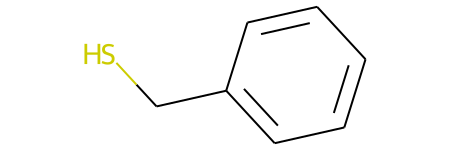

In [13]:
""" 
Annotating and drawing an example sulfur ligand - The first ligand we want to add 
"""
u1 = mda.Universe.from_smiles("C1=C(C=CC=C1)CS[H]")
AromaticSulfurSmilesString = 'C1=C(C=CC=C1)CS[H]'
m_aromatic = Chem.MolFromSmiles(AromaticSulfurSmilesString)
m_aromatic

""" 
Annotating and drawing an example sulfur ligand - The The second ligand we want to add in case we are adding in 
a Janus/Striped Nanoparticle 
"""
#u2 = mda.Universe.from_smiles("SCCO[H]")
#NonAromaticSulfurSmilesString_II = 'SCCO[H]'
#m_nonaromatic = Chem.MolFromSmiles(NonAromaticSulfurSmilesString_II)
#m_nonaromatic

In [7]:
C70 = mda.Universe.from_smiles("c1(c2c3c4c15)c6c7c8c2c9c%10c3c%11c%12c4c%13c%14c5c%15c6c%16c7c%17c%18c%19c%20c%21c%22c%23c%24c%21c%25c%26c%20c%18c%16c%27c%15c%14c%28c(c%25c%29c%24c%30c%31c%23c%32c%33c%22c%19c%34c%33c(c9c8c%34%17)c%35c%10c%11c(c%31c%32%35)c%36c%12c%13c%28c%29c%30%36)c%26%27")

/home/sang/anaconda3/lib/python3.9/site-packages/MDAnalysis/converters/RDKit.py:161: UserWarning:

No coordinates found in the RDKit molecule



In [14]:
C70

<Universe with 70 atoms>

In [32]:
C70.atoms

<AtomGroup with 70 atoms>

In [10]:
# Highlight a Substructure in a Molecule - Can we identify the benzene part and sulfur part?
ConvertedSmiles = Chem.MolToSmiles(Chem.MolFromSmiles('C1=CC=CN=C1'))
ConvertedSmiles
ExampleMartiniString = "CC(=O)CO" # Example smiles string that is compatible with MARTINI 
ConvertedSmiles2 = Chem.MolToSmiles(Chem.MolFromSmiles(ExampleMartiniString))
ConvertedSmiles2
m2  = Chem.MolFromSmiles(ConvertedSmiles2)
# Hence, we need to create a dictionary that catalogues the string with the relevant martini bead 
SmilesToMartiniDictionary = {}
SmilesToMartiniDictionary["CC(=O)CO"] = 'P2' # P2 Bead 
SmilesToMartiniDictionary["CC(=O)O"] = 'SP2' # SP2 Bead 
SmilesToMartiniDictionary["CC(C)O"] = 'P1' # P1 Bead 
SmilesToMartiniDictionary["CC(C)O"] = 'P1' # P1 Bead 

In [11]:
"""
This part links the lignad coordinates with the 
"""
# new feature
u1 = mda.Universe.from_smiles("c1ncncc1C(=O)[O-]")
# new feature
Molecule = u1.select_atoms('all')
Molecule.positions # Finds 
# Need to label each of the xyz coordinates with the relevant indices within the 

array([[ 0.17314848, -1.1145927 ,  0.39197075],
       [ 1.5194128 , -1.0466033 ,  0.3590107 ],
       [ 2.157392  ,  0.07085755, -0.03938667],
       [ 1.476814  ,  1.1653327 , -0.42088637],
       [ 0.13403021,  1.098846  , -0.3884807 ],
       [-0.5691921 , -0.01783159,  0.01008064],
       [-2.0446959 , -0.0272427 ,  0.02326303],
       [-2.647022  ,  0.9952549 , -0.33338112],
       [-2.666315  , -1.198298  ,  0.4404871 ],
       [-0.33424303, -2.0063305 ,  0.70988095],
       [ 3.2434862 ,  0.10529801, -0.05877192],
       [-0.44281575,  1.9753096 , -0.6937863 ]], dtype=float32)

In [12]:
m = Chem.MolFromSmiles('c1cc(C(=O)O)c(OC(=O)C)cc1')
substructure = Chem.MolFromSmarts('CC(=O)O')
print(m.GetSubstructMatches(substructure)) # Shows the indices of the molcule that matches the MARTINI bead 

# Find part of the smiles which is part of a ring 

ri = m.GetRingInfo().AtomRings()
for ring in ri:
    print(ring)

((10, 8, 9, 7),)
(0, 12, 11, 6, 2, 1)


In [36]:
"""
In the above situation, we can identify the 3 parts - the thiolated part, the saturated hydrocarbon chain attached 
to the benzene group, and the benzene group itself. 
"""
substructure = Chem.MolFromSmarts('SC')
print(m.GetSubstructMatches(substructure))

()


In [15]:
vector_plot(GenerateCore(10, 100))

In [8]:
"""
Generate an all-atomic based NP 
"""
SphereList = GenerateCore(30, 20)
AromaticSulfurSmilesString = 'C1=C(C=CC=C1)CS[H]'
PandasNPDataframe = AttachLigands('C1=C(C=CC=C1)CS[H]', ['S7'], ['C4'], SphereList)
#PandasNPDataframe = AttachLigandsMartini(MIMILigandPath, 'N1', 'R3', SphereList)
PandasNPDataframe

IndexError: index 0 is out of bounds for axis 0 with size 0

In [53]:
"""
Generating a Martini based NP - works both for Striped and Janus
"""
GroPath = "/home/sang/Desktop/GIT/Martini3-small-molecules/models/gros" # self-explanatory 
# ItpPath = "/home/sang/Desktop/GIT/Martini3-small-molecules/models/itps/cog-mono"  # not quite as self-explanatory
MIMILigandPath = GroPath + "/" + "1MIMI.gro" # First ligand 
NITLLigandPath = GroPath + "/" + "2NITL.gro" # Second ligand 
SphereList = GenerateCore(10, 50, "Striped") # Generate the NP core 
PandasNPDataframe, AttachmentList = AttachLigandsMartini([MIMILigandPath, NITLLigandPath], ['N1', 'N1'] , ['R3', 'R4'], 
                                         SphereList, 'Striped')

# Plotting the 3D plot of the new Martini NP 
fig = px.scatter_3d(PandasNPDataframe, x='X', y='Y', z='Z', color='name')
fig.show()


/home/sang/anaconda3/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning:

Failed to guess the mass for the following atom types: R

/tmp/ipykernel_20195/2478541945.py:411: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_20195/2478541945.py:411: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_20195/2478541945.py:580: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:root:     index         X          Y         Z NAME  name
0        0 -2.856066  13.138043  2.616390   N1  Lig1
1        1 -1.742618  15.079716  1.112182   N2  Lig1
2        2 -3.418456  15.725066  3.131586   R3  Lig1
3        3 -7.385994  11.460846 -1.306478   N1  Lig1
4        4 -6.424530  13.519893 -2.758516 

[-2.29367571 10.55102022  2.10119484]
[-5.93161195  9.20408147 -1.04921863]
[7.63796535 7.40816313 2.7893727 ]
[-7.87430443  6.95918355  3.2503984 ]
[ 9.48636728  5.16326522 -2.08555123]
[-10.46297097   3.36734688   0.4326767 ]
[10.78994744  1.57142854  1.45177217]
[-10.47743779  -0.22448979  -3.34258842]
[-10.36518419  -2.46938771   2.73222929]
[10.10476741 -4.26530605 -0.83715932]
[-9.14023799 -6.06122438 -0.8471152 ]
[ 7.42461938 -7.85714272  2.03478036]
[-6.41613289 -8.3061223   3.29265346]
[-4.76616644 -9.65306105 -2.25877522]
[  4.15980008 -10.10204064  -1.28251082]
[ -1.57279992 -10.55102022   2.68370423]
[ 0.38056582 10.1020412  -4.33635128]
[3.20909893 9.65306159 4.18570128]
[ 5.61894096  8.75510237 -3.5743103 ]
[-1.87218327  8.30612276  6.96442845]
[-3.54824508  7.85714316 -6.83192999]
[ 3.75808851  6.51020433 -8.03081687]
[2.74724924 6.06122472 8.75866347]
[-8.18540627  5.61224511 -4.74361025]
[-5.71597405  4.71428589  8.13038489]
[ -1.30301964   4.26530628 -10.05531259]
[7.

INFO:root:[[1, 49, 3.6971087430387493], [4, 50, 3.697108743038748], [7, 51, 3.697108743038748], [10, 52, 3.6971087430387497], [13, 53, 3.697108743038748], [16, 54, 3.6971087430387506], [19, 55, 3.6971087430387466], [22, 56, 3.6971087430387484], [25, 57, 3.6971087430387493], [28, 58, 3.697108743038748], [31, 59, 3.6971087430387497], [34, 60, 3.69710874303875], [37, 61, 3.697108743038748], [40, 62, 3.6971087430387493], [43, 63, 3.6971087430387497], [46, 64, 3.6971087430387475]], [[65, 193, 5.595705148767382], [69, 194, 5.59570514876738], [73, 195, 5.595705148767383], [77, 196, 5.59570514876738], [81, 197, 5.595705148767385], [85, 198, 5.595705148767384], [89, 199, 5.595705148767385], [93, 200, 5.595705148767385], [97, 201, 5.595705148767392], [101, 202, 5.595705148767382], [105, 203, 5.595705148767384], [109, 204, 5.595705148767382], [113, 205, 5.595705148767385], [117, 206, 5.595705148767385], [121, 207, 5.595705148767377], [125, 208, 5.595705148767387], [129, 209, 5.595705148767384], [

In [50]:
# Plotting the 3D plot of the new Martini NP 
fig = px.scatter_3d(PandasNPDataframe, x='X', y='Y', z='Z', color='name')
fig.show()

In [48]:
AttachmentList

['1 37 1 3.697108743038747 10000',
 '4 38 1 3.6971087430387457 10000',
 '7 39 1 3.69710874303875 10000',
 '10 40 1 3.697108743038747 10000',
 '13 41 1 3.697108743038748 10000',
 '16 42 1 3.6971087430387444 10000',
 '19 43 1 3.6971087430387457 10000',
 '22 44 1 3.6971087430387497 10000',
 '25 45 1 3.697108743038746 10000',
 '28 46 1 3.697108743038748 10000',
 '31 47 1 3.697108743038749 10000',
 '34 48 1 3.697108743038748 10000',
 '49 153 1 5.595705148767384 10000',
 '53 154 1 5.595705148767381 10000',
 '57 155 1 5.595705148767386 10000',
 '61 156 1 5.595705148767384 10000',
 '65 157 1 5.595705148767382 10000',
 '69 158 1 5.595705148767385 10000',
 '73 159 1 5.595705148767381 10000',
 '77 160 1 5.595705148767382 10000',
 '81 161 1 5.595705148767384 10000',
 '85 162 1 5.595705148767384 10000',
 '89 163 1 5.5957051487673874 10000',
 '93 164 1 5.595705148767382 10000',
 '97 165 1 5.595705148767384 10000',
 '101 166 1 5.595705148767386 10000',
 '105 167 1 5.595705148767381 10000',
 '109 168 

In [75]:
def LigandItpGenerator(MartiniItpFile_I, MartiniItpFile_II):
    """ Assigns indices of the individual top file 
    of each ligand to the full NP file 
    
    
    """
    MartiniAltItpI = GromacsTopologyFile('/home/sang/Desktop/GIT/Martini3-small-molecules/models/itps/cog-mono/2NITL_cog.top')
    MartiniAltItp_II = GromacsTopologyFile('/home/sang/Desktop/GIT/Martini3-small-molecules/models/itps/cog-mono/1MIMI_cog.top')
    
    indices_1 = [i for i in PandasNPDataframe[PandasNPDataframe['name'] == 'Lig1']['index'].iloc[::3]]
    # These indices need a variable to show the length of each ligand
    indices_2 = [i for i in PandasNPDataframe[PandasNPDataframe['name'] == 'Lig2']['index'].iloc[::4]]

    # get 
    
def CompoundItp():
    """
    """
    pass

/home/sang/anaconda3/lib/python3.9/site-packages/parmed/gromacs/gromacstop.py:444: GromacsWarning:

nrexcl 1 not currently supported

/home/sang/anaconda3/lib/python3.9/site-packages/parmed/gromacs/gromacstop.py:1022: GromacsWarning:

1 1-4 pairs were missing from the [ pairs ] section and were set to zero; make sure you know what you're doing!



In [74]:
MartiniAltItpI = GromacsTopologyFile('/home/sang/Desktop/GIT/Martini3-small-molecules/models/itps/cog-mono/2NITL_cog.top')
#MartiniAltItpI.__dict__
MartiniAltItp_II = GromacsTopologyFile('/home/sang/Desktop/GIT/Martini3-small-molecules/models/itps/cog-mono/1MIMI_cog.top')
MartiniAltItp_II.__dict__

/home/sang/anaconda3/lib/python3.9/site-packages/parmed/gromacs/gromacstop.py:444: GromacsWarning:

nrexcl 1 not currently supported

/home/sang/anaconda3/lib/python3.9/site-packages/parmed/gromacs/gromacstop.py:1022: GromacsWarning:

1 1-4 pairs were missing from the [ pairs ] section and were set to zero; make sure you know what you're doing!



{'atoms': AtomList([
 	<Atom N1 [0]; In 1MIMI 0>
 	<Atom N2 [1]; In 1MIMI 0>
 	<Atom R3 [2]; In 1MIMI 0>
 ]),
 'residues': ResidueList([
 	<Residue 1MIMI[0]>
 ]),
 'bonds': TrackedList([
 	<Bond <Atom N1 [0]; In 1MIMI 0>--<Atom N2 [1]; In 1MIMI 0>; type=<BondType; k=1195.029, req=2.850>>
 	<Bond <Atom N2 [1]; In 1MIMI 0>--<Atom R3 [2]; In 1MIMI 0>; type=<BondType; k=1195.029, req=2.600>>
 	<Bond <Atom N1 [0]; In 1MIMI 0>--<Atom R3 [2]; In 1MIMI 0>; type=<BondType; k=1195.029, req=3.250>>
 ]),
 'angles': TrackedList([
 ]),
 'dihedrals': TrackedList([
 ]),
 'rb_torsions': TrackedList([
 ]),
 'urey_bradleys': TrackedList([
 ]),
 'impropers': TrackedList([
 ]),
 'cmaps': TrackedList([
 ]),
 'trigonal_angles': TrackedList([
 ]),
 'out_of_plane_bends': TrackedList([
 ]),
 'pi_torsions': TrackedList([
 ]),
 'stretch_bends': TrackedList([
 ]),
 'torsion_torsions': TrackedList([
 ]),
 'chiral_frames': TrackedList([
 ]),
 'multipole_frames': TrackedList([
 ]),
 'adjusts': TrackedList([
 ]),
 'ac

In [68]:
PandasNPDataframe

,index,X,Y,Z,NAME,name
0,0,-3.192794,12.994693,2.924861,N1,Lig1
1,1,-2.076842,15.002405,1.511975,N2,Lig1
2,2,-3.821490,15.553489,3.500798,R3,Lig1
3,3,-8.184049,10.887445,-1.447643,N1,Lig1
4,4,-7.293805,13.072463,-2.753654,N2,Lig1
...,...,...,...,...,...,...
125,125,4.367754,-5.897436,-6.792862,Au,Core
126,126,1.299995,-6.410256,7.564299,Au,Core
127,127,-5.705156,-6.923077,-4.418393,Au,Core
128,128,-4.120500,-7.948718,4.454140,Au,Core


In [15]:
PandasNPDataframe.to_pickle('stripedPickle_Martini')

In [1]:
GenerateXYZ(PandasNPDataframe, 'MARTININP.xyz')

NameError: name 'GenerateXYZ' is not defined

In [28]:
set(PandasNPDataframe['name'])

{'Core', 'Lig1', 'Lig2'}

In [21]:
m = Chem.MolFromMolFile('c70.mol') # Read in the C70 mol 
mol1 = u1.atoms.convert_to("RDKIT") # Convert to rdkit 
u = mda.Universe('c70.pdb') # 
mol1 = u.atoms.convert_to("RDKIT", force=True)

/home/sang/anaconda3/lib/python3.8/site-packages/MDAnalysis/converters/RDKit.py:368: UserWarning: No hydrogen atom found in the topology. Forcing to continue the conversion.
  warnings.warn(


In [199]:
def itpConstraintParser():
    """
    Args:
        Placeholder
    Returns:
        Placeholder
    Raises:
        Placeholder 
    """
    file1 = open('/home/sang/Desktop/GIT/Martini3-small-molecules/models/itps/cog-mono/1MIMI_cog.itp', 'r')
    Lines = file1.readlines()
    for i,j  in enumerate(Lines):
        if '[constraints]' in j:
            print(i,j) 

13 [constraints]



In [179]:
gromacs.fileformats.__dict__

{'__name__': 'gromacs.fileformats',
 '__doc__': None,
 '__package__': 'gromacs.fileformats',
 '__loader__': <_frozen_importlib_external.SourceFileLoader at 0x7f310b111c10>,
 '__spec__': ModuleSpec(name='gromacs.fileformats', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7f310b111c10>, origin='/home/sang/anaconda3/lib/python3.8/site-packages/gromacs/fileformats/__init__.py', submodule_search_locations=['/home/sang/anaconda3/lib/python3.8/site-packages/gromacs/fileformats']),
 '__path__': ['/home/sang/anaconda3/lib/python3.8/site-packages/gromacs/fileformats'],
 '__file__': '/home/sang/anaconda3/lib/python3.8/site-packages/gromacs/fileformats/__init__.py',
 '__cached__': '/home/sang/anaconda3/lib/python3.8/site-packages/gromacs/fileformats/__pycache__/__init__.cpython-38.pyc',
 '__builtins__': {'__name__': 'builtins',
  '__doc__': "Built-in functions, exceptions, and other objects.\n\nNoteworthy: None is the `nil' object; Ellipsis represents `...' in slices.",
  '__pack

In [22]:
Molecule = mda.Universe('c70.pdb')
mol1 = u.atoms.convert_to("RDKIT", force=True)
C70List = [] 
for index, atoms in enumerate(u.atoms):
    C70List.append(list(atoms.position))
C70List

[[3.973, 0.535, -0.149],
 [3.773, -0.443, -1.066],
 [3.416, -1.699, -0.675],
 [3.228, 0.101, -2.174],
 [2.317, -0.592, -2.906],
 [3.061, 1.417, -1.949],
 [1.982, 2.069, -2.456],
 [3.503, 1.684, -0.702],
 [2.88, 2.634, 0.051],
 [3.809, 0.316, 1.179],
 [3.357, -0.977, 1.625],
 [2.456, -0.799, 2.613],
 [3.189, -1.963, 0.727],
 [2.151, -2.808, 0.82],
 [2.473, -2.406, -1.323],
 [1.711, -3.074, -0.43],
 [1.915, -1.898, -2.439],
 [0.602, -2.029, -2.674],
 [1.192, -0.021, -3.368],
 [0.159, -0.881, -3.235],
 [0.997, 1.299, -3.18],
 [-0.212, 1.78, -2.857],
 [1.276, 2.95, -1.728],
 [-0.042, 2.787, -1.971],
 [1.7, 3.271, -0.491],
 [0.827, 3.43, 0.515],
 [2.607, 2.453, 1.353],
 [1.383, 2.918, 1.635],
 [3.057, 1.237, 1.986],
 [2.247, 0.532, 2.804],
 [0.543, 2.281, 2.647],
 [1.047, 1.019, 3.244],
 [-3.627, 0.321, 2.123],
 [-4.038, -0.018, 0.876],
 [-3.878, 0.843, -0.169],
 [-3.851, -1.344, 0.7],
 [-3.5, -1.84, -0.517],
 [-3.299, -1.838, 1.826],
 [-2.39, -2.848, 1.764],
 [-3.141, -0.813, 2.693],
 [-2.

In [59]:
def ConvertC70Core(coordinate):
    """    
    Description 
    -----------
    
    Creates a MDAnalysis universe from the pdb input of the C70 file, and 
    creates a coarse-grained framework of the C70. 
    
    
    Parameters
    ----------
    coordinate: 
        path and file where the pdb file is.
    filename : str
    copy : bool
    dtype : data-type
    iterable : iterable object
    shape : int or tuple of int
    files : list of str
    
    Returns
    -------
    int
        Description of anonymous integer return value.
    """
    u = mda.Universe(coordinate) # Create Universe 
    CorePositions, CoreIndex = [], [] # Get positions and indices of the core 
    C70CGBeadPositions = [] # list to append the new 'coarse-grained' positions of the C70 Martini NP
    DistanceDict = {} 
    
    CorePositions = [[index, atoms.position] for index, atoms in enumerate(u.atoms)]
    
    for index, atoms in enumerate(u.atoms): # loop over the indices and atoms within the universe 
        DistanceDict[index] = []
        # Get the distance between atoms in the core positions  
        for items in CorePositions: # each element here is [index, atom.position]
            Distance = distance.euclidean(items[1], atoms.position) # get the distance between the atoms and the core
            Entry = [index, items[0], Distance] # index of position A and index of position B, and the distance between 
            DistanceDict[index].append(Entry) # Append this list 
    ClosestAtomsDistance = [] # List to store the atoms with the closest distances
    
    # Sort each entry by distance 
    for key in DistanceDict.keys():
        DistanceDict[key] = sorted(DistanceDict[key], key=itemgetter(2)) # sort entries by closest distance 
        DistanceDict[key][1][0:2] = sorted(DistanceDict[key][1][0:2]) # Get first two index 
        ClosestAtomsDistance.append(DistanceDict[key][1]) 
    
    # Remove duplicate entries 
    UniqueSetsCoordinates = [list(x) for x in set(tuple(x) for x in ClosestAtomsDistance)]       
    
    # Take the indices in the unique data and compute the averge coordinates
    for entry in UniqueSetsCoordinates:
        data = [list(CorePositions[entry[0]][1]), list(CorePositions[entry[1]][1])]
        averaged = np.average(data, axis=0)
        C70CGBeadPositions.append(averaged)
        
        
    return C70CGBeadPositions

def ConstructNPNetwork():
    """
    """
    pass



In [60]:
NPPositions = ConvertC70Core('c70.pdb')
C70 = [[i[0], i[1], i[2]] for i in NPPositions]
C70

[[0.39249998, 1.5395, -3.0185],
 [-3.22, -1.3255, 2.2595],
 [2.67, -2.3855, 0.77349997],
 [-2.4299998, 1.8634999, -1.5074999],
 [-1.606, 0.954, 3.481],
 [-3.0265, -2.316, -0.58150005],
 [0.67550004, -0.451, -3.3014998],
 [-0.352, -3.4235, 1.117],
 [1.7544999, -0.30650002, -3.137],
 [-3.3734999, -0.2395, -1.4844999],
 [-3.575, -1.5910001, 1.263],
 [1.2969999, -2.2680001, 2.3925],
 [-1.8330001, -2.8455, 2.144],
 [-3.9445, -0.681, 0.788],
 [-1.1865, 2.7435, 2.0095],
 [3.273, -1.47, 1.176],
 [3.5005, -0.17099999, -1.62],
 [-3.331, 0.917, 2.2545],
 [-1.7175, -0.22600001, 3.6505],
 [-1.9135001, -1.921, -2.0595],
 [-0.8375, 3.21, -0.313],
 [3.891, 0.42550004, 0.515],
 [0.617, 2.8685, -1.8495],
 [1.629, 2.5095, -2.092],
 [1.6470001, 0.77550006, 3.024],
 [-3.6725001, 0.629, -0.774],
 [-1.1835, -2.3495, 2.967],
 [-3.8325, 0.1515, 1.4994999],
 [0.0075000077, -3.082, -1.2435],
 [-1.3045, 0.26, -2.8885],
 [3.1445, 0.759, -2.0615],
 [-2.273, -3.0545, -0.09700002],
 [0.1355, -0.594, 3.6539998],
 [2.6

In [61]:
"""
Plotting the new C70 core and plotting the 3D scatter plot to see what it looks like
"""
df = pd.DataFrame(NPPositions, columns = ['X','Y','Z'])
fig = px.scatter_3d(df, x='X', y='Y', z='Z')
#fig = px.scatter_3d(dfCore, x='X', y='Y', z='Z')
fig.show()

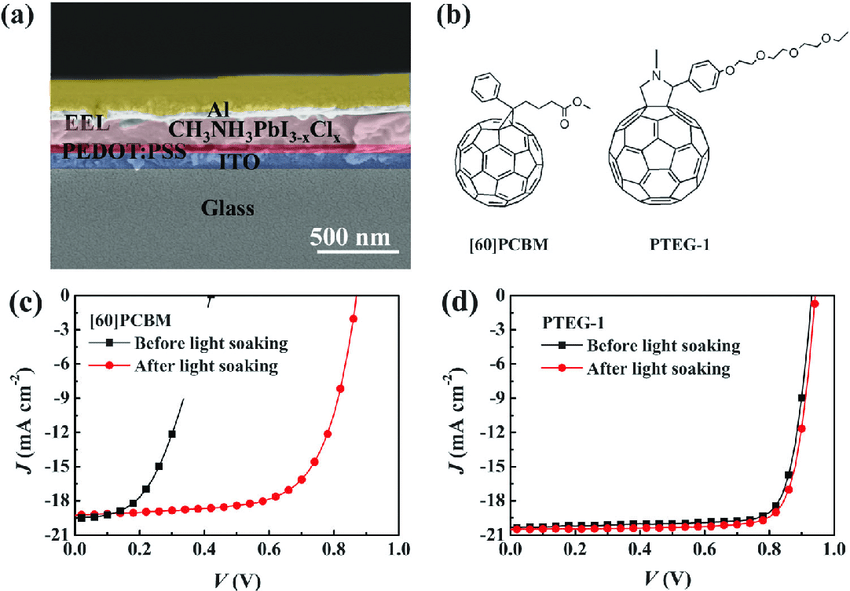

In [40]:
"""
The smiles for the ligand 

Links on information about the C60/C70 ligand bonded NP
-------------------------------------------------------

poly(3-hexyl-thiophene) (P3HT)

phenyl-C-61-butyric acid methyl ester (PCBM).

https://pubchem.ncbi.nlm.nih.gov/compound/3-Hexylthiophene

https://pubchem.ncbi.nlm.nih.gov/compound/6_6_-Phenyl-C61-butyric-acid-methyl-ester

https://chemrxiv.org/engage/chemrxiv/article-details/60c74b9abb8c1a44713db259

https://research.rug.nl/en/publications/resolving-donor-acceptor-interfaces-and-charge-carrier-energy-lev

https://www.americanelements.com/60-pcbm-6-6-phenyl-c61-butyric-acid-methyl-ester-160848-22-6

http://www-jmg.ch.cam.ac.uk/data/molecules/misc/c70.html
 
https://en.wikipedia.org/wiki/Phenyl-C61-butyric_acid_methyl_ester - information on its application
as potential solar cells 

"""


# Which ligand do I need to attach by? 


P3HT = 'CCCCCCC1=CSC=C1'
m_P3HT = Chem.MolFromSmiles(P3HT)
# Universe 
u_P3HT = mda.Universe.from_smiles(P3HT)
# Need to add index 
u_P3HT_object = u_P3HT.select_atoms('all')
#mol_with_atom_index(m_aromatic)

"""
<Atom 1: C0 of type CA resid 1 and segid SYSTEM>
<Atom 2: C1 of type C resid 1 and segid SYSTEM>
<Atom 3: C2 of type C resid 1 and segid SYSTEM>
<Atom 4: C3 of type C resid 1 and segid SYSTEM>
<Atom 5: C4 of type C resid 1 and segid SYSTEM>
<Atom 6: C5 of type C resid 1 and segid SYSTEM>
<Atom 7: C6 of type C resid 1 and segid SYSTEM>
<Atom 8: C7 of type C resid 1 and segid SYSTEM>
<Atom 9: S8 of type S resid 1 and segid SYSTEM>
<Atom 10: C9 of type C resid 1 and segid SYSTEM>
<Atom 11: C10 of type C resid 1 and segid SYSTEM>
<Atom 12: H11 of type H resid 1 and segid SYSTEM>
<Atom 13: H12 of type H resid 1 and segid SYSTEM>
<Atom 14: H13 of type H resid 1 and segid SYSTEM>
<Atom 15: H14 of type H resid 1 and segid SYSTEM>
<Atom 16: H15 of type H resid 1 and segid SYSTEM>
<Atom 17: H16 of type H resid 1 and segid SYSTEM>
<Atom 18: H17 of type H resid 1 and segid SYSTEM>
<Atom 19: H18 of type H resid 1 and segid SYSTEM>
<Atom 20: H19 of type H resid 1 and segid SYSTEM>
<Atom 21: H20 of type H resid 1 and segid SYSTEM>
<Atom 22: H21 of type H resid 1 and segid SYSTEM>
<Atom 23: H22 of type H resid 1 and segid SYSTEM>
<Atom 24: H23 of type H resid 1 and segid SYSTEM>
<Atom 25: H24 of type H resid 1 and segid SYSTEM>
<Atom 26: H25 of type H resid 1 and segid SYSTEM>
<Atom 27: H26 of type H resid 1 and segid SYSTEM>


Testing attaching ligands onto C70 
"""
PCBM = 'C1=CC=CC(=C1)CCCCC(=O)OC'
m_PCBM = Chem.MolFromSmiles(PCBM)
u_PCBM = mda.Universe.from_smiles(PCBM)


LigandList = [] 
Sphere = []
Xplot, Yplot, Zplot = [], [], []
XplotSphere, YplotSphere, ZplotSphere = [], [], []
# Select Atom attached to the core 
#FirstAtom = u_P3HT.select_atoms('name {}'.format('C0')) # Pick out the atoms attached
# Select end atom on the ligand 
#LastAtom = u_P3HT.select_atoms('name {}'.format('S8')) # Pick out the last atom at the tip of the ligand 
#FirstAtom = u_P3HT.select_atoms('name {}'.format('S8')) # Pick out the atoms attached
# Select end atom on the ligand 
#LastAtom = u_P3HT.select_atoms('name {}'.format('C0')) # Pick out the last atom at the tip of the ligand 
FirstAtom = u_PCBM.select_atoms('name {}'.format('C6')) # Pick out the atoms attached
# Select end atom on the ligand 
LastAtom = u_PCBM.select_atoms('name {}'.format('C10')) # Pick out the last atom at the tip of the ligand 
TransformationList, NameList = [], []
# Find the vector representing the direction from the sulfur to the tip of the ligand. 
LigandAlignmentVector = (FirstAtom.positions- LastAtom.positions)[0]
Molecule = u_PCBM.select_atoms('all')
for i,j in enumerate(Molecule.positions):
    vector = (j - FirstAtom.positions)[0]
    vector[0] = LigandAlignmentVector[0] - vector[0]
    vector[1] = LigandAlignmentVector[1] - vector[1]    
    vector[2] = LigandAlignmentVector[2] - vector[2]
    if vector[0] == -math.inf:
        pass
    if vector[0] == 0.0:
        pass
    else:
        TransformationList.append([vector, Molecule.atoms[i].type])      
    
unitVector = np.linalg.norm(LigandAlignmentVector)
vec1 = LigandAlignmentVector.tolist()
for index in range(0, len(C70)):
    vec2 = C70[index] # get cartesian coordinates of the core atom 
    # Find the rotation matrix that aligns ligand vector representation to the NP surface vector point representation 
    TransformationVector = rotation_matrix_from_vectors(vec1, vec2)  
    vec1_rot = TransformationVector.dot(vec1) # Rotate the vector to match the surface point on the sphere 
    # TODO 
    unitVectorabs = np.linalg.norm(LigandAlignmentVector)  
    vecMultiplier = vec1_rot/unitVectorabs * 4 # Controls how far we want the ligands to be placed away from
                                               # the NP surface
    # TODO
    Sphere.append(vec1_rot.tolist())

#LigandList.append(vec1_rot.tolist())
# Get the factors to translate the vector 
for trans in TransformationList:
    #if vec1_rot[0] > 0 and vec1_rot[1] > 0 and vec1_rot[2] > 0:   # (+ , +, +)
    LigandAtomcoordinate = TransformationVector.dot(trans[0])
    LigandAtomcoordinate[0] = LigandAtomcoordinate[0] + vecMultiplier[0]
    LigandAtomcoordinate[1] = LigandAtomcoordinate[1] + vecMultiplier[1]
    LigandAtomcoordinate[2] = LigandAtomcoordinate[2] + vecMultiplier[2]
    LigandList.append(LigandAtomcoordinate.tolist()) # Append coordinates of the 
    NameList.append(trans[1]) # Append the names of the atoms 
        
# Append the coordinates of the ligands 
for index, entry in enumerate(LigandList):
    #ax.plot3D(entry[0], entry[1], entry[2], 'red')
    Xplot.append(entry[0])
    Yplot.append(entry[1])
    Zplot.append(entry[2])
    
# Add in the ligand index 
LigandConstituent = [atom.name for atom in Molecule]
Ligands = []
for index in range(0, len(Sphere)): 
    Ligands = Ligands + LigandConstituent
    
SphereName = [] 
# Append the coordinates of the sphere 
for entry in Sphere:
    #ax.plot3D(entry[0], entry[1], entry[2], 'red')
    XplotSphere.append(entry[0])
    YplotSphere.append(entry[1])
    ZplotSphere.append(entry[2])
    SphereName.append('Au')
    
dfLigand = pd.DataFrame(list(zip(Xplot, Yplot, Zplot, Ligands)), columns =['X', 'Y', 'Z', 'NAME'])
dfLigand['name'] = 'Ligand'
dfCore = pd.DataFrame(list(zip(XplotSphere, YplotSphere, ZplotSphere, SphereName)), columns =['X', 'Y', 'Z', 'NAME'])
dfCore['name'] = 'Core'
Total = dfLigand.append(dfCore)


TypeError: object of type 'Universe' has no len()

In [77]:
Total

,X,Y,Z,NAME,name
0,5.960394,-3.473137,0.851449,C0,Ligand
1,6.119952,-2.117413,0.640176,C1,Ligand
2,6.610378,-1.682692,-0.590572,C2,Ligand
3,6.938083,-2.575874,-1.597337,C3,Ligand
4,6.779544,-3.911732,-1.385665,C4,Ligand
...,...,...,...,...,...
40,2.935128,-3.844288,-1.229751,Au,Core
41,-3.917849,2.962100,0.884443,Au,Core
42,4.238599,2.002422,-1.711841,Au,Core
43,3.915089,-1.196146,2.854317,Au,Core


In [78]:
fig = px.scatter_3d(Total, x='X', y='Y', z='Z', color='name')
#fig = px.scatter_3d(dfCore, x='X', y='Y', z='Z')
fig.show()

In [51]:
GenerateXYZ(Total, 'new.xyz')

In [34]:
vector

array([-16.936071  ,   0.21350878,  -2.7219892 ], dtype=float32)

In [23]:
for i in u_P3HT.atoms:
    print(i)

<Atom 1: C0 of type CA resid 1 and segid SYSTEM>
<Atom 2: C1 of type C resid 1 and segid SYSTEM>
<Atom 3: C2 of type C resid 1 and segid SYSTEM>
<Atom 4: C3 of type C resid 1 and segid SYSTEM>
<Atom 5: C4 of type C resid 1 and segid SYSTEM>
<Atom 6: C5 of type C resid 1 and segid SYSTEM>
<Atom 7: C6 of type C resid 1 and segid SYSTEM>
<Atom 8: C7 of type C resid 1 and segid SYSTEM>
<Atom 9: S8 of type S resid 1 and segid SYSTEM>
<Atom 10: C9 of type C resid 1 and segid SYSTEM>
<Atom 11: C10 of type C resid 1 and segid SYSTEM>
<Atom 12: H11 of type H resid 1 and segid SYSTEM>
<Atom 13: H12 of type H resid 1 and segid SYSTEM>
<Atom 14: H13 of type H resid 1 and segid SYSTEM>
<Atom 15: H14 of type H resid 1 and segid SYSTEM>
<Atom 16: H15 of type H resid 1 and segid SYSTEM>
<Atom 17: H16 of type H resid 1 and segid SYSTEM>
<Atom 18: H17 of type H resid 1 and segid SYSTEM>
<Atom 19: H18 of type H resid 1 and segid SYSTEM>
<Atom 20: H19 of type H resid 1 and segid SYSTEM>
<Atom 21: H20 of t

In [36]:
SphereList = GenerateCore(10, 20)
SphereList

[[0.0, 10.0, 0.0],
 [-3.293043372158504, 8.947368421052632, 3.0166974801980206],
 [0.5366054686279798, 7.894736842105264, -6.114342545600823],
 [4.437250612693587, 6.842105263157895, 5.787607672261262],
 [-8.029008272447404, 5.7894736842105265, -1.4202185116400012],
 [7.430908708905336, 4.736842105263158, -4.726935860546545],
 [-2.4134348850096936, 3.68421052631579, 8.977857475678826],
 [-4.446613324391361, 2.6315789473684212, -8.561683373444298],
 [9.275384024876669, 1.578947368421053, 3.3873553694318743],
 [-9.230644113001569, 0.5263157894736847, 3.8102757050980163],
 [4.232585436290039, -0.5263157894736836, -9.044789229952027],
 [2.955296325164402, -1.578947368421053, 9.421950373368883],
 [-8.347149180670506, -2.6315789473684204, -4.837343568468028],
 [9.079754606968212, -3.68421052631579, -1.9961585796282524],
 [-5.065134773100864, -4.7368421052631575, 7.204632995519659],
 [-1.047831076633954, -5.7894736842105265, -8.086040099744368],
 [5.576466989837349, -6.842105263157894, 4.6998

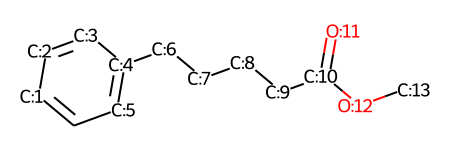

In [38]:
# C70
Phenyl_C61_Butyric_Acid_Methyl_Ester = 'C1=CC=CC(=C1)CCCCC(=O)OC'
C70BAME = Chem.MolFromSmiles(Phenyl_C61_Butyric_Acid_Methyl_Ester)
u_C70BAME = mda.Universe.from_smiles(Phenyl_C61_Butyric_Acid_Methyl_Ester)
# Need to add index 
u_C70BAME_object = u_C70BAME.select_atoms('all')
#u_C70BAME_object.write("u_C70BAME.xyz")
mol_with_atom_index(C70BAME) # C6 is the attaching ligand 

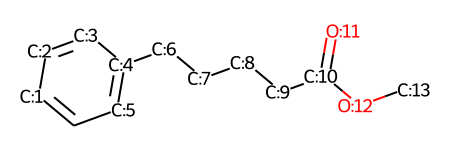

In [41]:
PCBM = 'C1=CC=CC(=C1)CCCCC(=O)OC'
m_PCBM = Chem.MolFromSmiles(PCBM)
mol_with_atom_index(m_PCBM)

#u_PCBM = mda.Universe.from_smiles(PCBM)
#for i in u_PCBM.select_atoms('all'):
#    print(i)
    


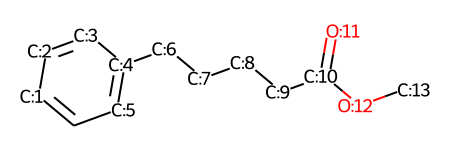

In [17]:
m_PCBM

In [ ]:
# https://stackoverflow.com/questions/53075481/how-do-i-cluster-a-list-of-geographic-points-by-distance


import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import math

points = np.array([[33.    , 41.    ],
       [33.9693, 41.3923],
       [33.6074, 41.277 ],
       [34.4823, 41.919 ],
       [34.3702, 41.1424],
       [34.3931, 41.078 ],
       [34.2377, 41.0576],
       [34.2395, 41.0211],
       [34.4443, 41.3499],
       [34.3812, 40.9793]])


def distance(origin, destination): #found here https://gist.github.com/rochacbruno/2883505
    lat1, lon1 = origin[0],origin[1]
    lat2, lon2 = destination[0],destination[1]
    radius = 6371 # km
    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

def create_clusters(number_of_clusters,points):
    kmeans = KMeans(n_clusters=number_of_clusters, random_state=0).fit(points)
    l_array = np.array([[label] for label in kmeans.labels_])
    clusters = np.append(points,l_array,axis=1)
    return clusters

def validate_solution(max_dist,clusters):
    _, __, n_clust = clusters.max(axis=0)
    n_clust = int(n_clust)
    for i in range(n_clust):
        two_d_cluster=clusters[clusters[:,2] == i][:,np.array([True, True, False])]
        if not validate_cluster(max_dist,two_d_cluster):
            return False
        else:
            continue
    return True

def validate_cluster(max_dist,cluster):
    distances = cdist(cluster,cluster, lambda ori,des: int(round(distance(ori,des))))
    print(distances)
    print(30*'-')
    for item in distances.flatten():
        if item > max_dist:
            return False
    return True

if __name__ == '__main__':
    for i in range(2,len(points)):
        print(i)
        print(validate_solution(20,create_clusters(i,points)))


In [96]:
DistIndex1Index2
UniqueIndex1Index2Distances = [list(i) for i in list(set(map(tuple, DistIndex1Index2)))]

NameError: name 'DistIndex1Index2' is not defined

In [9]:
import os                                                                                                                                                                                                  
import numpy as np                                                                                                                                                                                         
import itertools                                                                                                                                                                                           
import requests                                                                                                                                                                                            
import collections                                                                                                                                                                                         
import random                                                                                                                                                                                              
                                                                                                                                                                                                           
# RDKit libaries                                                                                                                                                                                           
from rdkit import Chem                                                                                                                                                                                     
from rdkit.Chem import AllChem                                                                                                                                                                             
from rdkit.Chem import ChemicalFeatures                                                                                                                                                                   
from rdkit.Chem import rdchem                                                                                                                                                                              
from rdkit.Chem import rdMolDescriptors                                                                                                                                                                    
from rdkit import RDConfig                                                                                                                                                                                 
                                                                                                                                                                                                           
# Boilerplate libraries                                                                                                                                                                                    
import sys                                                                                                                                                                                                 
import re                                                                                                                                                                                                  
import math                                                                                                                                                                                                
import scipy                                                                                                                                                                                               
                                                                                                                                                                                                           
# scipy libaries                                                                                                                                                                                           
from scipy.sparse import csr_matrix                                                                                                                                                                        
from scipy.sparse.csgraph import floyd_warshall                                                                                                                                                            
from scipy.spatial import ConvexHull, convex_hull_plot_2d           

def read_DG_data(DGfile):                                                                                                                                                                                  
    # Reads Delta G_OW for fragments into dictionary                                                                                                                                                       
    DG_data = {}                                                                                                                                                                                           
    with open(DGfile) as f:                                                                                                                                                                                
        for line in f:                                                                                                                                                                                     
            (key,val) = line.rstrip().split()                                                                                                                                                              
            DG_data[key] = float(val)                                                                                                                                                                      
                                                                                                                                                                                                           
    return DG_data                                                                                                                                                                                         
                                                                                                                                                                                                           
def include_weights(A,w):                                                                                                                                                                                  
    # Weights atoms by setting diagonal components                                                                                                                                                         
    A_weighted = np.copy(A)                                                                                                                                                                                
    for i,weight in enumerate(w):                                                                                                                                                                          
        A_weighted[i,i] = weight     
        
def get_smarts_matches(mol):                                                                                                                                                                               
    #Get matches to SMARTS strings                                                                                                                                                                         
    smarts_strings = {                                                                                                                                                                                     
    'S([O-])(=O)(=O)O'  :    'Qa',                                                                                                                                                                         
    'S([O-])(=O)(=O)[C;!$(*F)]'   :    'Q0'}                                                                                                                                                               
    matched_maps = []                                                                                                                                                                                      
    matched_beads = []                                                                                                                                                                                     
    for smarts in smarts_strings:                                                                                                                                                                          
        matches = mol.GetSubstructMatches(Chem.MolFromSmarts(smarts))                                                                                                                                      
        for match in matches:                                                                                                                                                                              
            matched_maps.append(list(match))                                                                                                                                                               
            matched_beads.append(smarts_strings[smarts])                                                                                                                                                   
                                                                                                                                                                                                           
    return matched_maps,matched_beads           

In [130]:
DataPath = '/home/sang/Desktop/GIT/MDNPPackage/temp/cgparam/fragment_DGs.dat'

In [131]:
read_DG_data(DataPath)

{'CC': 8.2656,
 'CN': -6.0844,
 'CO': -7.9212,
 'CF': 2.3534,
 'CCl': 3.8458,
 'C=C': 5.166,
 'C=O': -3.9032,
 'C#C': -0.1722,
 'CCC': 12.5706,
 'CCN': -1.148,
 'CCO': -2.296,
 'CCF': 5.7974,
 'CCCl': 8.4378,
 'FCF': 1.6646,
 'FCCl': 3.5588,
 'ClCF': 3.5588,
 'ClCCl': 6.4288,
 'CNC': -3.0422,
 'COC': -0.9184,
 'CC=C': 9.6432,
 'CC=O': -0.0574,
 'CC#N': -0.2296,
 'NC=N': -8.036,
 'NC=O': -8.7822,
 'OC=O': -2.6978,
 'FC=C': 5.8548,
 'ClC=C': 8.2082,
 'NN=C': -1.8368,
 'ON=C': -1.7794,
 'CC#C': 5.2808,
 'CC(C)C': 12.3984,
 'CC(C)N': -0.287,
 'CC(C)O': 0.2296,
 'CC(C)F': 6.1992,
 'CC(C)Cl': 8.5526,
 'CC(F)F': 4.5346,
 'CC(F)Cl': 7.2898,
 'CC(Cl)F': 7.2898,
 'CC(Cl)Cl': 9.8728,
 'FC(F)F': 5.5678,
 'FC(F)Cl': 5.6252,
 'FC(Cl)F': 5.6252,
 'FC(Cl)Cl': 7.3472,
 'ClC(F)F': 5.6252,
 'ClC(F)Cl': 7.3472,
 'ClC(Cl)F': 7.3472,
 'ClC(Cl)Cl': 9.5858,
 'CN(C)C': -0.8036,
 'CC(C)=C': 10.7338,
 'CC(C)=O': -1.6646,
 'CC(N)=N': -5.74,
 'CC(N)=O': -6.314,
 'CC(O)=O': -0.6888,
 'CC(F)=C': 7.4046,
 'CC(Cl)=C':

In [ ]:
def write_gro(mol_name,bead_types,coords0,gro_name):                                                                                                                                                       
    #write gro file                                                                                                                                                                                        
    conf = mol.GetConformer(0)                                                                                                                                                                             
    with open(gro_name,'w') as gro:                                                                                                                                                                        
        gro.write('single molecule of {}\n'.format(mol_name))                                                                                                                                              
        gro.write('{}\n'.format(len(bead_types)))                                                                                                                                                          
        i = 1                                                                                                                                                                                              
        for bead,xyz in zip(bead_types,coords0):                                                                                                                                                           
            gro.write('{:5d}{:5}{:>5}{:5d}{:8.3f}{:8.3f}{:8.3f}\n'.format(1,mol_name,bead,i,xyz[0],xyz[1],xyz[2]))                                                                                         
            i += 1                                                                                                                                                                                         
        gro.write('5.0 5.0 5.0')         